# TODO:
* Wrapper for reward clipping to [-1, 1] (same reason like image normalization)
* checking hyperparameters from paper
* checking used parameters
* * Adding results to a Dataframe and save to hard drive (to compare with other models)

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
!nvidia-smi

Tue May 25 14:45:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   48C    P0    83W / 149W |    354MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Auswahl des Spiels

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [3]:
# Hier kann das Spiel übergeben werden
game = "Pong-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


## Fire Wrapper

In [4]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

## Max And Skip Env Wrapper

In [5]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

## Noop Reset Env Wrapper

In [6]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

## Scaled Float Frame Wrapper

In [7]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

## Episodic Life Wrapper

In [8]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

## Clip Reward Wrapper

In [9]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

## Resize & Grayscale Wrapper

In [10]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

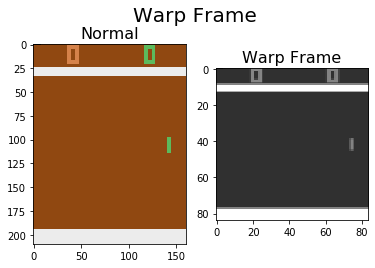

In [11]:
""" 
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

## Frame Stack Wrapper

In [12]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

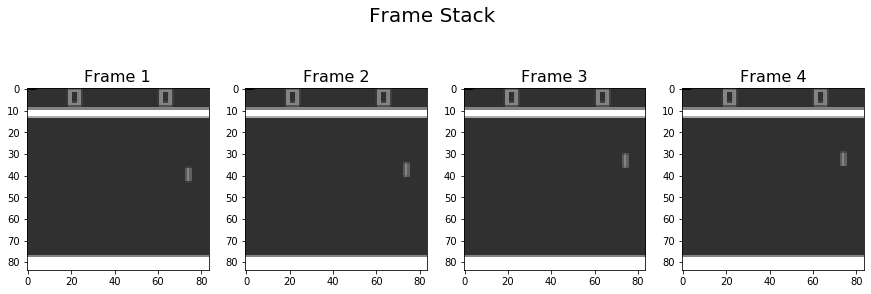

In [13]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
plt.show()

## Erstellen des Environments

In [14]:
def make_env(env_name):
    env = gym.make(env_name)
    #env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    #env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)

""" saving the properties for csv """

MODE = "NoEpisodicLife_NoClipReward_lr_1e-3_5e-3"
PATH = "WEIGHTS/" + game + "/" + MODE + "/"
print(PATH)

WEIGHTS/Pong-v0/NoEpisodicLife_NoClipReward_lr_1e-3_5e-3/


# Actor Network und Critic Network

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Network Parameter
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
ACTOR_OUTPUT = env.action_space.n # Anzahl der möglichen Aktionen
CRITIC_OUTPUT = 1 # Bewertung der gewählten Aktion
ACTOR_LEARNING_RATE = 25e-6
CRITIC_LEARNING_RATE = 25e-6

# neuronales Netz
net_input = Input(shape=INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
x = Activation("relu")(x)
x = Flatten()(x)
x = Dense(512)(x)
x = Activation("relu")(x)


'''Aufspalten des Netzes in Actor und Critic'''

# Actor - wählt eine Aktion
actor_x = Dense(ACTOR_OUTPUT, kernel_initializer='he_uniform')(x)
actor_output = Activation("softmax")(actor_x)

ACTOR = Model(inputs=net_input, outputs=actor_output)
ACTOR.compile(loss="categorical_crossentropy", optimizer=Adam(lr=ACTOR_LEARNING_RATE))

# Critic - bewertet gewählte Aktion
critic_x = Dense(CRITIC_OUTPUT)(x)
critic_output = Activation("linear")(critic_x)

CRITIC = Model(inputs=net_input, outputs=critic_output)
CRITIC.compile(loss="mse", optimizer=Adam(lr=CRITIC_LEARNING_RATE))

# Aktion wählen

In [16]:
def get_action(state):
    policy = ACTOR.predict(state)[0]
    action = np.random.choice(env.action_space.n, p=policy) # Aktionen, welche Wahrscheinlichkeit zu Aktion
    return action

In [17]:
def remember (state, action, reward):
    STATES.append(state)
    # Erstellen eines One Hot Labels für die Aktion
    action_onehot = np.zeros([env.action_space.n])
    action_onehot[action] = 1
    ACTIONS.append(action_onehot)
    REWARDS.append(reward)

In [18]:
def discount_rewards(rewards):
    gamma = 0.99
    running_add = 0
    discounted_r = np.zeros_like(rewards)
    for i in reversed(range(0, len(rewards))):
        if rewards[i] != 0: # Pong
            running_add = 0
        running_add = running_add * gamma + rewards[i]
        discounted_r[i] = running_add

    discounted_r -= np.mean(discounted_r) # normalisieren
    discounted_r /= np.std(discounted_r) # teilen durch Standardabweichung

    return discounted_r

In [19]:
def replay_episode(STATES, ACTIONS, REWARDS):
    states = np.vstack(STATES)
    actions = np.vstack(ACTIONS)

    # discount rewards
    discounted_r = discount_rewards(REWARDS)

    # Critic predictions
    values = CRITIC.predict(states)[:, 0]

    # Advantagewerte berechnen
    advantages = discounted_r - values

    # Trainieren der Netzwerke ACTOR und CRITIC
    ACTOR.fit(states, actions, sample_weight=advantages, epochs=1, verbose=0)
    CRITIC.fit(states, discounted_r, epochs=1, verbose=0)

    # leeren des Episoden Buffers
    STATES, ACTIONS, REWARDS = [], [], []

# Training /Spielen

In [20]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

-21.0

In [ ]:
EPISODES = 15_000
REWARD_LIST = []
MEAN_LIST = []
BEST_MEAN_REWARD = INITIAL_MEAN_REWARD

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False

    # Episoden Buffer
    STATES, ACTIONS, REWARDS = [], [], []
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)
        
        # Transition im Episoden Buffer speichern
        remember(state, action, reward)

        # aktualisieren des States
        state = next_state
        
        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward


        if done:
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2),"\tBestMean:", BEST_MEAN_REWARD)

            # Übernahme des höchsten Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward
        
                # trainierte Gewichte speichern
                import os
                try:
                    os.makedirs(PATH)
                except FileExistsError:
                    # Pfad existiert bereits
                    pass
                ACTOR.save_weights(PATH + "Best_ACTOR.h5")
                CRITIC.save_weights(PATH + "Best_CRITIC.h5")

            replay_episode(STATES, ACTIONS, REWARDS)

Episode: 1 	Reward: -20.0 	Mean: -20.0 	BestMean: -21.0


W0525 14:45:19.012101 139769341744960 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Episode: 2 	Reward: -20.0 	Mean: -20.0 	BestMean: -20.0
Episode: 3 	Reward: -20.0 	Mean: -20.0 	BestMean: -20.0
Episode: 4 	Reward: -21.0 	Mean: -20.25 	BestMean: -20.0
Episode: 5 	Reward: -20.0 	Mean: -20.2 	BestMean: -20.0
Episode: 6 	Reward: -20.0 	Mean: -20.17 	BestMean: -20.0
Episode: 7 	Reward: -20.0 	Mean: -20.14 	BestMean: -20.0
Episode: 8 	Reward: -21.0 	Mean: -20.25 	BestMean: -20.0
Episode: 9 	Reward: -19.0 	Mean: -20.11 	BestMean: -20.0
Episode: 10 	Reward: -21.0 	Mean: -20.2 	BestMean: -20.0
Episode: 11 	Reward: -21.0 	Mean: -20.3 	BestMean: -20.0
Episode: 12 	Reward: -19.0 	Mean: -20.2 	BestMean: -20.0
Episode: 13 	Reward: -20.0 	Mean: -20.2 	BestMean: -20.0
Episode: 14 	Reward: -20.0 	Mean: -20.1 	BestMean: -20.0
Episode: 15 	Reward: -19.0 	Mean: -20.0 	BestMean: -20.0
Episode: 16 	Reward: -21.0 	Mean: -20.1 	BestMean: -20.0
Episode: 17 	Reward: -20.0 	Mean: -20.1 	BestMean: -20.0
Episode: 18 	Reward: -20.0 	Mean: -20.0 	BestMean: -20.0
Episode: 19 	Reward: -19.0 	Mean: 

Episode: 145 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.6
Episode: 146 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.6
Episode: 147 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.6
Episode: 148 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.6
Episode: 149 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.6
Episode: 150 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.6
Episode: 151 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.6
Episode: 152 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.6
Episode: 153 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.6
Episode: 154 	Reward: -18.0 	Mean: -19.9 	BestMean: -19.6
Episode: 155 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.6
Episode: 156 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.6
Episode: 157 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.6
Episode: 158 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.6
Episode: 159 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.6
Episode: 160 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.6
Episode: 161 	Reward: -19.0 	Mean: -19.9 	BestMean: -19.6
Episode: 162 	

Episode: 287 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.6
Episode: 288 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.6
Episode: 289 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.6
Episode: 290 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.6
Episode: 291 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.6
Episode: 292 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 293 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.6
Episode: 294 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.6
Episode: 295 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.6
Episode: 296 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.6
Episode: 297 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.6
Episode: 298 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.6
Episode: 299 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.6
Episode: 300 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.6
Episode: 301 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.6
Episode: 302 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.6
Episode: 303 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.6
Episode: 304 	

Episode: 429 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.4
Episode: 430 	Reward: -19.0 	Mean: -20.3 	BestMean: -19.4
Episode: 431 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.4
Episode: 432 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.4
Episode: 433 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.4
Episode: 434 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.4
Episode: 435 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.4
Episode: 436 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.4
Episode: 437 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.4
Episode: 438 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.4
Episode: 439 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.4
Episode: 440 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.4
Episode: 441 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.4
Episode: 442 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.4
Episode: 443 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.4
Episode: 444 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.4
Episode: 445 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.4
Episode: 446 	

Episode: 571 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.4
Episode: 572 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.4
Episode: 573 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.4
Episode: 574 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.4
Episode: 575 	Reward: -19.0 	Mean: -20.5 	BestMean: -19.4
Episode: 576 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.4
Episode: 577 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.4
Episode: 578 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.4
Episode: 579 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.4
Episode: 580 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.4
Episode: 581 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.4
Episode: 582 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.4
Episode: 583 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.4
Episode: 584 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.4
Episode: 585 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.4
Episode: 586 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.4
Episode: 587 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.4
Episode: 588 	

Episode: 713 	Reward: -20.0 	Mean: -19.7 	BestMean: -19.4
Episode: 714 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.4
Episode: 715 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.4
Episode: 716 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.4
Episode: 717 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.4
Episode: 718 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.4
Episode: 719 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.4
Episode: 720 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.4
Episode: 721 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.4
Episode: 722 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.4
Episode: 723 	Reward: -18.0 	Mean: -20.2 	BestMean: -19.4
Episode: 724 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.4
Episode: 725 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.4
Episode: 726 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.4
Episode: 727 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.4
Episode: 728 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.4
Episode: 729 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.4
Episode: 730 	

Episode: 855 	Reward: -17.0 	Mean: -19.6 	BestMean: -19.4
Episode: 856 	Reward: -19.0 	Mean: -19.5 	BestMean: -19.4
Episode: 857 	Reward: -21.0 	Mean: -19.5 	BestMean: -19.4
Episode: 858 	Reward: -20.0 	Mean: -19.5 	BestMean: -19.4
Episode: 859 	Reward: -20.0 	Mean: -19.6 	BestMean: -19.4
Episode: 860 	Reward: -19.0 	Mean: -19.5 	BestMean: -19.4
Episode: 861 	Reward: -20.0 	Mean: -19.4 	BestMean: -19.4
Episode: 862 	Reward: -20.0 	Mean: -19.6 	BestMean: -19.4
Episode: 863 	Reward: -20.0 	Mean: -19.6 	BestMean: -19.4
Episode: 864 	Reward: -19.0 	Mean: -19.5 	BestMean: -19.4
Episode: 865 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.4
Episode: 866 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.4
Episode: 867 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.4
Episode: 868 	Reward: -19.0 	Mean: -19.8 	BestMean: -19.4
Episode: 869 	Reward: -19.0 	Mean: -19.7 	BestMean: -19.4
Episode: 870 	Reward: -18.0 	Mean: -19.6 	BestMean: -19.4
Episode: 871 	Reward: -20.0 	Mean: -19.6 	BestMean: -19.4
Episode: 872 	

Episode: 997 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.4
Episode: 998 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.4
Episode: 999 	Reward: -19.0 	Mean: -19.9 	BestMean: -19.4
Episode: 1000 	Reward: -19.0 	Mean: -19.8 	BestMean: -19.4
Episode: 1001 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.4
Episode: 1002 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.4
Episode: 1003 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.4
Episode: 1004 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.4
Episode: 1005 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.4
Episode: 1006 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.4
Episode: 1007 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.4
Episode: 1008 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.4
Episode: 1009 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.4
Episode: 1010 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.4
Episode: 1011 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.4
Episode: 1012 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.4
Episode: 1013 	Reward: -18.0 	Mean: -19.8 	BestMean: -19.4


Episode: 1136 	Reward: -18.0 	Mean: -19.7 	BestMean: -19.2
Episode: 1137 	Reward: -19.0 	Mean: -19.5 	BestMean: -19.2
Episode: 1138 	Reward: -21.0 	Mean: -19.5 	BestMean: -19.2
Episode: 1139 	Reward: -21.0 	Mean: -19.7 	BestMean: -19.2
Episode: 1140 	Reward: -19.0 	Mean: -19.6 	BestMean: -19.2
Episode: 1141 	Reward: -21.0 	Mean: -19.8 	BestMean: -19.2
Episode: 1142 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.2
Episode: 1143 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.2
Episode: 1144 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1145 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.2
Episode: 1146 	Reward: -18.0 	Mean: -20.2 	BestMean: -19.2
Episode: 1147 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.2
Episode: 1148 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.2
Episode: 1149 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.2
Episode: 1150 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.2
Episode: 1151 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.2
Episode: 1152 	Reward: -20.0 	Mean: -20.3 	BestMean: -19

Episode: 1275 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.2
Episode: 1276 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.2
Episode: 1277 	Reward: -19.0 	Mean: -19.9 	BestMean: -19.2
Episode: 1278 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.2
Episode: 1279 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.2
Episode: 1280 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.2
Episode: 1281 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1282 	Reward: -18.0 	Mean: -20.0 	BestMean: -19.2
Episode: 1283 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1284 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.2
Episode: 1285 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.2
Episode: 1286 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.2
Episode: 1287 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.2
Episode: 1288 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.2
Episode: 1289 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.2
Episode: 1290 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.2
Episode: 1291 	Reward: -20.0 	Mean: -20.2 	BestMean: -19

Episode: 1414 	Reward: -18.0 	Mean: -19.8 	BestMean: -19.2
Episode: 1415 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.2
Episode: 1416 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.2
Episode: 1417 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.2
Episode: 1418 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1419 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1420 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.2
Episode: 1421 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1422 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1423 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1424 	Reward: -18.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1425 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.2
Episode: 1426 	Reward: -19.0 	Mean: -19.9 	BestMean: -19.2
Episode: 1427 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.2
Episode: 1428 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.2
Episode: 1429 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.2
Episode: 1430 	Reward: -21.0 	Mean: -19.9 	BestMean: -19

Episode: 1553 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1554 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.2
Episode: 1555 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1556 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.2
Episode: 1557 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1558 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.2
Episode: 1559 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1560 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.2
Episode: 1561 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1562 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.2
Episode: 1563 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.2
Episode: 1564 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.2
Episode: 1565 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.2
Episode: 1566 	Reward: -19.0 	Mean: -19.8 	BestMean: -19.2
Episode: 1567 	Reward: -19.0 	Mean: -19.8 	BestMean: -19.2
Episode: 1568 	Reward: -20.0 	Mean: -19.7 	BestMean: -19.2
Episode: 1569 	Reward: -20.0 	Mean: -19.7 	BestMean: -19

Episode: 1692 	Reward: -20.0 	Mean: -19.4 	BestMean: -19.2
Episode: 1693 	Reward: -20.0 	Mean: -19.5 	BestMean: -19.2
Episode: 1694 	Reward: -20.0 	Mean: -19.6 	BestMean: -19.2
Episode: 1695 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.2
Episode: 1696 	Reward: -19.0 	Mean: -19.8 	BestMean: -19.2
Episode: 1697 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.2
Episode: 1698 	Reward: -19.0 	Mean: -19.7 	BestMean: -19.2
Episode: 1699 	Reward: -19.0 	Mean: -19.6 	BestMean: -19.2
Episode: 1700 	Reward: -20.0 	Mean: -19.6 	BestMean: -19.2
Episode: 1701 	Reward: -20.0 	Mean: -19.7 	BestMean: -19.2
Episode: 1702 	Reward: -16.0 	Mean: -19.3 	BestMean: -19.2
Episode: 1703 	Reward: -19.0 	Mean: -19.2 	BestMean: -19.2
Episode: 1704 	Reward: -20.0 	Mean: -19.2 	BestMean: -19.2
Episode: 1705 	Reward: -19.0 	Mean: -19.1 	BestMean: -19.2
Episode: 1706 	Reward: -19.0 	Mean: -19.1 	BestMean: -19.1
Episode: 1707 	Reward: -19.0 	Mean: -19.0 	BestMean: -19.1
Episode: 1708 	Reward: -20.0 	Mean: -19.1 	BestMean: -19

Episode: 1831 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1832 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1833 	Reward: -18.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1834 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1835 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1836 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1837 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1838 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1839 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1840 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.0
Episode: 1841 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1842 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1843 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1844 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1845 	Reward: -19.0 	Mean: -19.9 	BestMean: -19.0
Episode: 1846 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.0
Episode: 1847 	Reward: -20.0 	Mean: -20.0 	BestMean: -19

Episode: 1970 	Reward: -20.0 	Mean: -20.0 	BestMean: -18.9
Episode: 1971 	Reward: -19.0 	Mean: -19.8 	BestMean: -18.9
Episode: 1972 	Reward: -21.0 	Mean: -20.0 	BestMean: -18.9
Episode: 1973 	Reward: -17.0 	Mean: -19.6 	BestMean: -18.9
Episode: 1974 	Reward: -21.0 	Mean: -19.7 	BestMean: -18.9
Episode: 1975 	Reward: -18.0 	Mean: -19.4 	BestMean: -18.9
Episode: 1976 	Reward: -19.0 	Mean: -19.3 	BestMean: -18.9
Episode: 1977 	Reward: -20.0 	Mean: -19.3 	BestMean: -18.9
Episode: 1978 	Reward: -20.0 	Mean: -19.5 	BestMean: -18.9
Episode: 1979 	Reward: -17.0 	Mean: -19.2 	BestMean: -18.9
Episode: 1980 	Reward: -18.0 	Mean: -19.0 	BestMean: -18.9
Episode: 1981 	Reward: -18.0 	Mean: -18.9 	BestMean: -18.9
Episode: 1982 	Reward: -21.0 	Mean: -18.9 	BestMean: -18.9
Episode: 1983 	Reward: -20.0 	Mean: -19.2 	BestMean: -18.9
Episode: 1984 	Reward: -20.0 	Mean: -19.1 	BestMean: -18.9
Episode: 1985 	Reward: -19.0 	Mean: -19.2 	BestMean: -18.9
Episode: 1986 	Reward: -20.0 	Mean: -19.3 	BestMean: -18

Episode: 2109 	Reward: -17.0 	Mean: -19.9 	BestMean: -18.9
Episode: 2110 	Reward: -20.0 	Mean: -19.8 	BestMean: -18.9
Episode: 2111 	Reward: -19.0 	Mean: -19.7 	BestMean: -18.9
Episode: 2112 	Reward: -21.0 	Mean: -19.9 	BestMean: -18.9
Episode: 2113 	Reward: -18.0 	Mean: -19.6 	BestMean: -18.9
Episode: 2114 	Reward: -18.0 	Mean: -19.4 	BestMean: -18.9
Episode: 2115 	Reward: -18.0 	Mean: -19.1 	BestMean: -18.9
Episode: 2116 	Reward: -19.0 	Mean: -18.9 	BestMean: -18.9
Episode: 2117 	Reward: -20.0 	Mean: -19.0 	BestMean: -18.9
Episode: 2118 	Reward: -20.0 	Mean: -19.0 	BestMean: -18.9
Episode: 2119 	Reward: -20.0 	Mean: -19.3 	BestMean: -18.9
Episode: 2120 	Reward: -19.0 	Mean: -19.2 	BestMean: -18.9
Episode: 2121 	Reward: -20.0 	Mean: -19.3 	BestMean: -18.9
Episode: 2122 	Reward: -20.0 	Mean: -19.2 	BestMean: -18.9
Episode: 2123 	Reward: -21.0 	Mean: -19.5 	BestMean: -18.9
Episode: 2124 	Reward: -21.0 	Mean: -19.8 	BestMean: -18.9
Episode: 2125 	Reward: -18.0 	Mean: -19.8 	BestMean: -18

Episode: 2248 	Reward: -20.0 	Mean: -19.6 	BestMean: -18.5
Episode: 2249 	Reward: -20.0 	Mean: -19.7 	BestMean: -18.5
Episode: 2250 	Reward: -21.0 	Mean: -20.0 	BestMean: -18.5
Episode: 2251 	Reward: -17.0 	Mean: -19.8 	BestMean: -18.5
Episode: 2252 	Reward: -18.0 	Mean: -19.7 	BestMean: -18.5
Episode: 2253 	Reward: -20.0 	Mean: -19.6 	BestMean: -18.5
Episode: 2254 	Reward: -20.0 	Mean: -19.5 	BestMean: -18.5
Episode: 2255 	Reward: -20.0 	Mean: -19.4 	BestMean: -18.5
Episode: 2256 	Reward: -21.0 	Mean: -19.5 	BestMean: -18.5
Episode: 2257 	Reward: -20.0 	Mean: -19.7 	BestMean: -18.5
Episode: 2258 	Reward: -19.0 	Mean: -19.6 	BestMean: -18.5
Episode: 2259 	Reward: -17.0 	Mean: -19.3 	BestMean: -18.5
Episode: 2260 	Reward: -21.0 	Mean: -19.3 	BestMean: -18.5
Episode: 2261 	Reward: -21.0 	Mean: -19.7 	BestMean: -18.5
Episode: 2262 	Reward: -20.0 	Mean: -19.9 	BestMean: -18.5
Episode: 2263 	Reward: -20.0 	Mean: -19.9 	BestMean: -18.5
Episode: 2264 	Reward: -20.0 	Mean: -19.9 	BestMean: -18

Episode: 2387 	Reward: -20.0 	Mean: -19.6 	BestMean: -18.5
Episode: 2388 	Reward: -20.0 	Mean: -19.6 	BestMean: -18.5
Episode: 2389 	Reward: -18.0 	Mean: -19.5 	BestMean: -18.5
Episode: 2390 	Reward: -20.0 	Mean: -19.6 	BestMean: -18.5
Episode: 2391 	Reward: -21.0 	Mean: -19.8 	BestMean: -18.5
Episode: 2392 	Reward: -19.0 	Mean: -19.7 	BestMean: -18.5
Episode: 2393 	Reward: -19.0 	Mean: -19.6 	BestMean: -18.5
Episode: 2394 	Reward: -18.0 	Mean: -19.4 	BestMean: -18.5
Episode: 2395 	Reward: -20.0 	Mean: -19.4 	BestMean: -18.5
Episode: 2396 	Reward: -19.0 	Mean: -19.4 	BestMean: -18.5
Episode: 2397 	Reward: -20.0 	Mean: -19.4 	BestMean: -18.5
Episode: 2398 	Reward: -21.0 	Mean: -19.5 	BestMean: -18.5
Episode: 2399 	Reward: -19.0 	Mean: -19.6 	BestMean: -18.5
Episode: 2400 	Reward: -20.0 	Mean: -19.6 	BestMean: -18.5
Episode: 2401 	Reward: -20.0 	Mean: -19.5 	BestMean: -18.5
Episode: 2402 	Reward: -21.0 	Mean: -19.7 	BestMean: -18.5
Episode: 2403 	Reward: -20.0 	Mean: -19.8 	BestMean: -18

Episode: 2526 	Reward: -21.0 	Mean: -19.7 	BestMean: -18.5
Episode: 2527 	Reward: -20.0 	Mean: -19.8 	BestMean: -18.5
Episode: 2528 	Reward: -19.0 	Mean: -19.8 	BestMean: -18.5
Episode: 2529 	Reward: -20.0 	Mean: -19.9 	BestMean: -18.5
Episode: 2530 	Reward: -17.0 	Mean: -19.5 	BestMean: -18.5
Episode: 2531 	Reward: -17.0 	Mean: -19.3 	BestMean: -18.5
Episode: 2532 	Reward: -18.0 	Mean: -19.0 	BestMean: -18.5
Episode: 2533 	Reward: -21.0 	Mean: -19.2 	BestMean: -18.5
Episode: 2534 	Reward: -20.0 	Mean: -19.2 	BestMean: -18.5
Episode: 2535 	Reward: -18.0 	Mean: -19.1 	BestMean: -18.5
Episode: 2536 	Reward: -21.0 	Mean: -19.1 	BestMean: -18.5
Episode: 2537 	Reward: -19.0 	Mean: -19.0 	BestMean: -18.5
Episode: 2538 	Reward: -20.0 	Mean: -19.1 	BestMean: -18.5
Episode: 2539 	Reward: -20.0 	Mean: -19.1 	BestMean: -18.5
Episode: 2540 	Reward: -21.0 	Mean: -19.5 	BestMean: -18.5
Episode: 2541 	Reward: -20.0 	Mean: -19.8 	BestMean: -18.5
Episode: 2542 	Reward: -21.0 	Mean: -20.1 	BestMean: -18

Episode: 2665 	Reward: -21.0 	Mean: -20.0 	BestMean: -18.5
Episode: 2666 	Reward: -20.0 	Mean: -20.1 	BestMean: -18.5
Episode: 2667 	Reward: -20.0 	Mean: -20.1 	BestMean: -18.5
Episode: 2668 	Reward: -19.0 	Mean: -20.1 	BestMean: -18.5
Episode: 2669 	Reward: -20.0 	Mean: -20.0 	BestMean: -18.5
Episode: 2670 	Reward: -19.0 	Mean: -19.8 	BestMean: -18.5
Episode: 2671 	Reward: -19.0 	Mean: -19.8 	BestMean: -18.5
Episode: 2672 	Reward: -17.0 	Mean: -19.5 	BestMean: -18.5
Episode: 2673 	Reward: -20.0 	Mean: -19.4 	BestMean: -18.5
Episode: 2674 	Reward: -18.0 	Mean: -19.3 	BestMean: -18.5
Episode: 2675 	Reward: -19.0 	Mean: -19.1 	BestMean: -18.5
Episode: 2676 	Reward: -18.0 	Mean: -18.9 	BestMean: -18.5
Episode: 2677 	Reward: -18.0 	Mean: -18.7 	BestMean: -18.5
Episode: 2678 	Reward: -20.0 	Mean: -18.8 	BestMean: -18.5
Episode: 2679 	Reward: -20.0 	Mean: -18.8 	BestMean: -18.5
Episode: 2680 	Reward: -19.0 	Mean: -18.8 	BestMean: -18.5
Episode: 2681 	Reward: -21.0 	Mean: -19.0 	BestMean: -18

Episode: 2804 	Reward: -18.0 	Mean: -19.1 	BestMean: -18.5
Episode: 2805 	Reward: -21.0 	Mean: -19.4 	BestMean: -18.5
Episode: 2806 	Reward: -19.0 	Mean: -19.2 	BestMean: -18.5
Episode: 2807 	Reward: -19.0 	Mean: -19.0 	BestMean: -18.5
Episode: 2808 	Reward: -19.0 	Mean: -19.1 	BestMean: -18.5
Episode: 2809 	Reward: -20.0 	Mean: -19.2 	BestMean: -18.5
Episode: 2810 	Reward: -20.0 	Mean: -19.4 	BestMean: -18.5
Episode: 2811 	Reward: -21.0 	Mean: -19.5 	BestMean: -18.5
Episode: 2812 	Reward: -21.0 	Mean: -19.7 	BestMean: -18.5
Episode: 2813 	Reward: -18.0 	Mean: -19.6 	BestMean: -18.5
Episode: 2814 	Reward: -18.0 	Mean: -19.6 	BestMean: -18.5
Episode: 2815 	Reward: -18.0 	Mean: -19.3 	BestMean: -18.5
Episode: 2816 	Reward: -20.0 	Mean: -19.4 	BestMean: -18.5
Episode: 2817 	Reward: -19.0 	Mean: -19.4 	BestMean: -18.5
Episode: 2818 	Reward: -21.0 	Mean: -19.6 	BestMean: -18.5
Episode: 2819 	Reward: -20.0 	Mean: -19.6 	BestMean: -18.5
Episode: 2820 	Reward: -19.0 	Mean: -19.5 	BestMean: -18

Episode: 2943 	Reward: -20.0 	Mean: -19.6 	BestMean: -17.7
Episode: 2944 	Reward: -20.0 	Mean: -19.6 	BestMean: -17.7
Episode: 2945 	Reward: -20.0 	Mean: -19.7 	BestMean: -17.7
Episode: 2946 	Reward: -20.0 	Mean: -19.9 	BestMean: -17.7
Episode: 2947 	Reward: -17.0 	Mean: -19.6 	BestMean: -17.7
Episode: 2948 	Reward: -20.0 	Mean: -19.7 	BestMean: -17.7
Episode: 2949 	Reward: -18.0 	Mean: -19.4 	BestMean: -17.7
Episode: 2950 	Reward: -18.0 	Mean: -19.4 	BestMean: -17.7
Episode: 2951 	Reward: -20.0 	Mean: -19.3 	BestMean: -17.7
Episode: 2952 	Reward: -19.0 	Mean: -19.2 	BestMean: -17.7
Episode: 2953 	Reward: -19.0 	Mean: -19.1 	BestMean: -17.7
Episode: 2954 	Reward: -17.0 	Mean: -18.8 	BestMean: -17.7
Episode: 2955 	Reward: -19.0 	Mean: -18.7 	BestMean: -17.7
Episode: 2956 	Reward: -21.0 	Mean: -18.8 	BestMean: -17.7
Episode: 2957 	Reward: -20.0 	Mean: -19.1 	BestMean: -17.7
Episode: 2958 	Reward: -20.0 	Mean: -19.1 	BestMean: -17.7
Episode: 2959 	Reward: -19.0 	Mean: -19.2 	BestMean: -17

Episode: 3082 	Reward: -18.0 	Mean: -18.6 	BestMean: -17.7
Episode: 3083 	Reward: -19.0 	Mean: -18.5 	BestMean: -17.7
Episode: 3084 	Reward: -17.0 	Mean: -18.3 	BestMean: -17.7
Episode: 3085 	Reward: -20.0 	Mean: -18.3 	BestMean: -17.7
Episode: 3086 	Reward: -20.0 	Mean: -18.3 	BestMean: -17.7
Episode: 3087 	Reward: -21.0 	Mean: -18.6 	BestMean: -17.7
Episode: 3088 	Reward: -21.0 	Mean: -18.8 	BestMean: -17.7
Episode: 3089 	Reward: -21.0 	Mean: -19.3 	BestMean: -17.7
Episode: 3090 	Reward: -20.0 	Mean: -19.5 	BestMean: -17.7
Episode: 3091 	Reward: -20.0 	Mean: -19.7 	BestMean: -17.7
Episode: 3092 	Reward: -16.0 	Mean: -19.5 	BestMean: -17.7
Episode: 3093 	Reward: -20.0 	Mean: -19.6 	BestMean: -17.7
Episode: 3094 	Reward: -20.0 	Mean: -19.9 	BestMean: -17.7
Episode: 3095 	Reward: -17.0 	Mean: -19.6 	BestMean: -17.7
Episode: 3096 	Reward: -19.0 	Mean: -19.5 	BestMean: -17.7
Episode: 3097 	Reward: -18.0 	Mean: -19.2 	BestMean: -17.7
Episode: 3098 	Reward: -13.0 	Mean: -18.4 	BestMean: -17

Episode: 3221 	Reward: -20.0 	Mean: -19.4 	BestMean: -17.7
Episode: 3222 	Reward: -18.0 	Mean: -19.3 	BestMean: -17.7
Episode: 3223 	Reward: -20.0 	Mean: -19.3 	BestMean: -17.7
Episode: 3224 	Reward: -20.0 	Mean: -19.4 	BestMean: -17.7
Episode: 3225 	Reward: -19.0 	Mean: -19.4 	BestMean: -17.7
Episode: 3226 	Reward: -19.0 	Mean: -19.4 	BestMean: -17.7
Episode: 3227 	Reward: -18.0 	Mean: -19.3 	BestMean: -17.7
Episode: 3228 	Reward: -18.0 	Mean: -19.1 	BestMean: -17.7
Episode: 3229 	Reward: -20.0 	Mean: -19.2 	BestMean: -17.7
Episode: 3230 	Reward: -15.0 	Mean: -18.7 	BestMean: -17.7
Episode: 3231 	Reward: -19.0 	Mean: -18.6 	BestMean: -17.7
Episode: 3232 	Reward: -20.0 	Mean: -18.8 	BestMean: -17.7
Episode: 3233 	Reward: -17.0 	Mean: -18.5 	BestMean: -17.7
Episode: 3234 	Reward: -20.0 	Mean: -18.5 	BestMean: -17.7
Episode: 3235 	Reward: -20.0 	Mean: -18.6 	BestMean: -17.7
Episode: 3236 	Reward: -20.0 	Mean: -18.7 	BestMean: -17.7
Episode: 3237 	Reward: -18.0 	Mean: -18.7 	BestMean: -17

Episode: 3360 	Reward: -18.0 	Mean: -18.8 	BestMean: -17.7
Episode: 3361 	Reward: -19.0 	Mean: -18.9 	BestMean: -17.7
Episode: 3362 	Reward: -20.0 	Mean: -19.0 	BestMean: -17.7
Episode: 3363 	Reward: -17.0 	Mean: -18.9 	BestMean: -17.7
Episode: 3364 	Reward: -19.0 	Mean: -18.9 	BestMean: -17.7
Episode: 3365 	Reward: -20.0 	Mean: -19.0 	BestMean: -17.7
Episode: 3366 	Reward: -19.0 	Mean: -19.0 	BestMean: -17.7
Episode: 3367 	Reward: -21.0 	Mean: -19.2 	BestMean: -17.7
Episode: 3368 	Reward: -19.0 	Mean: -19.1 	BestMean: -17.7
Episode: 3369 	Reward: -19.0 	Mean: -19.1 	BestMean: -17.7
Episode: 3370 	Reward: -19.0 	Mean: -19.2 	BestMean: -17.7
Episode: 3371 	Reward: -19.0 	Mean: -19.2 	BestMean: -17.7
Episode: 3372 	Reward: -20.0 	Mean: -19.2 	BestMean: -17.7
Episode: 3373 	Reward: -21.0 	Mean: -19.6 	BestMean: -17.7
Episode: 3374 	Reward: -21.0 	Mean: -19.8 	BestMean: -17.7
Episode: 3375 	Reward: -20.0 	Mean: -19.8 	BestMean: -17.7
Episode: 3376 	Reward: -18.0 	Mean: -19.7 	BestMean: -17

Episode: 3499 	Reward: -19.0 	Mean: -18.9 	BestMean: -17.7
Episode: 3500 	Reward: -18.0 	Mean: -18.8 	BestMean: -17.7
Episode: 3501 	Reward: -19.0 	Mean: -18.8 	BestMean: -17.7
Episode: 3502 	Reward: -20.0 	Mean: -18.9 	BestMean: -17.7
Episode: 3503 	Reward: -17.0 	Mean: -18.5 	BestMean: -17.7
Episode: 3504 	Reward: -21.0 	Mean: -18.6 	BestMean: -17.7
Episode: 3505 	Reward: -20.0 	Mean: -18.9 	BestMean: -17.7
Episode: 3506 	Reward: -19.0 	Mean: -19.0 	BestMean: -17.7
Episode: 3507 	Reward: -18.0 	Mean: -18.9 	BestMean: -17.7
Episode: 3508 	Reward: -18.0 	Mean: -18.9 	BestMean: -17.7
Episode: 3509 	Reward: -19.0 	Mean: -18.9 	BestMean: -17.7
Episode: 3510 	Reward: -17.0 	Mean: -18.8 	BestMean: -17.7
Episode: 3511 	Reward: -20.0 	Mean: -18.9 	BestMean: -17.7
Episode: 3512 	Reward: -18.0 	Mean: -18.7 	BestMean: -17.7
Episode: 3513 	Reward: -17.0 	Mean: -18.7 	BestMean: -17.7
Episode: 3514 	Reward: -19.0 	Mean: -18.5 	BestMean: -17.7
Episode: 3515 	Reward: -18.0 	Mean: -18.3 	BestMean: -17

Episode: 3638 	Reward: -19.0 	Mean: -18.5 	BestMean: -17.4
Episode: 3639 	Reward: -18.0 	Mean: -18.6 	BestMean: -17.4
Episode: 3640 	Reward: -19.0 	Mean: -18.6 	BestMean: -17.4
Episode: 3641 	Reward: -19.0 	Mean: -18.7 	BestMean: -17.4
Episode: 3642 	Reward: -16.0 	Mean: -18.3 	BestMean: -17.4
Episode: 3643 	Reward: -17.0 	Mean: -17.9 	BestMean: -17.4
Episode: 3644 	Reward: -19.0 	Mean: -18.1 	BestMean: -17.4
Episode: 3645 	Reward: -17.0 	Mean: -18.0 	BestMean: -17.4
Episode: 3646 	Reward: -19.0 	Mean: -18.2 	BestMean: -17.4
Episode: 3647 	Reward: -19.0 	Mean: -18.2 	BestMean: -17.4
Episode: 3648 	Reward: -19.0 	Mean: -18.2 	BestMean: -17.4
Episode: 3649 	Reward: -19.0 	Mean: -18.3 	BestMean: -17.4
Episode: 3650 	Reward: -19.0 	Mean: -18.3 	BestMean: -17.4
Episode: 3651 	Reward: -18.0 	Mean: -18.2 	BestMean: -17.4
Episode: 3652 	Reward: -18.0 	Mean: -18.4 	BestMean: -17.4
Episode: 3653 	Reward: -16.0 	Mean: -18.3 	BestMean: -17.4
Episode: 3654 	Reward: -19.0 	Mean: -18.3 	BestMean: -17

Episode: 3777 	Reward: -19.0 	Mean: -17.3 	BestMean: -17.2
Episode: 3778 	Reward: -20.0 	Mean: -17.7 	BestMean: -17.2
Episode: 3779 	Reward: -18.0 	Mean: -17.7 	BestMean: -17.2
Episode: 3780 	Reward: -17.0 	Mean: -17.6 	BestMean: -17.2
Episode: 3781 	Reward: -19.0 	Mean: -17.8 	BestMean: -17.2
Episode: 3782 	Reward: -17.0 	Mean: -17.8 	BestMean: -17.2
Episode: 3783 	Reward: -18.0 	Mean: -17.7 	BestMean: -17.2
Episode: 3784 	Reward: -18.0 	Mean: -17.5 	BestMean: -17.2
Episode: 3785 	Reward: -19.0 	Mean: -17.9 	BestMean: -17.2
Episode: 3786 	Reward: -18.0 	Mean: -18.3 	BestMean: -17.2
Episode: 3787 	Reward: -14.0 	Mean: -17.8 	BestMean: -17.2
Episode: 3788 	Reward: -19.0 	Mean: -17.7 	BestMean: -17.2
Episode: 3789 	Reward: -20.0 	Mean: -17.9 	BestMean: -17.2
Episode: 3790 	Reward: -20.0 	Mean: -18.2 	BestMean: -17.2
Episode: 3791 	Reward: -18.0 	Mean: -18.1 	BestMean: -17.2
Episode: 3792 	Reward: -21.0 	Mean: -18.5 	BestMean: -17.2
Episode: 3793 	Reward: -17.0 	Mean: -18.4 	BestMean: -17

Episode: 3917 	Reward: -21.0 	Mean: -18.5 	BestMean: -17.2
Episode: 3918 	Reward: -21.0 	Mean: -18.7 	BestMean: -17.2
Episode: 3919 	Reward: -16.0 	Mean: -18.4 	BestMean: -17.2
Episode: 3920 	Reward: -21.0 	Mean: -18.7 	BestMean: -17.2
Episode: 3921 	Reward: -16.0 	Mean: -18.5 	BestMean: -17.2
Episode: 3922 	Reward: -15.0 	Mean: -18.0 	BestMean: -17.2
Episode: 3923 	Reward: -21.0 	Mean: -18.5 	BestMean: -17.2
Episode: 3924 	Reward: -18.0 	Mean: -18.4 	BestMean: -17.2
Episode: 3925 	Reward: -20.0 	Mean: -18.8 	BestMean: -17.2
Episode: 3926 	Reward: -18.0 	Mean: -18.7 	BestMean: -17.2
Episode: 3927 	Reward: -18.0 	Mean: -18.4 	BestMean: -17.2
Episode: 3928 	Reward: -15.0 	Mean: -17.8 	BestMean: -17.2
Episode: 3929 	Reward: -19.0 	Mean: -18.1 	BestMean: -17.2
Episode: 3930 	Reward: -18.0 	Mean: -17.8 	BestMean: -17.2
Episode: 3931 	Reward: -19.0 	Mean: -18.1 	BestMean: -17.2
Episode: 3932 	Reward: -19.0 	Mean: -18.5 	BestMean: -17.2
Episode: 3933 	Reward: -20.0 	Mean: -18.4 	BestMean: -17

Episode: 4056 	Reward: -21.0 	Mean: -18.2 	BestMean: -17.1
Episode: 4057 	Reward: -18.0 	Mean: -18.3 	BestMean: -17.1
Episode: 4058 	Reward: -18.0 	Mean: -18.5 	BestMean: -17.1
Episode: 4059 	Reward: -18.0 	Mean: -18.4 	BestMean: -17.1
Episode: 4060 	Reward: -18.0 	Mean: -18.4 	BestMean: -17.1
Episode: 4061 	Reward: -19.0 	Mean: -18.7 	BestMean: -17.1
Episode: 4062 	Reward: -16.0 	Mean: -18.4 	BestMean: -17.1
Episode: 4063 	Reward: -16.0 	Mean: -18.1 	BestMean: -17.1
Episode: 4064 	Reward: -19.0 	Mean: -18.2 	BestMean: -17.1
Episode: 4065 	Reward: -16.0 	Mean: -17.9 	BestMean: -17.1
Episode: 4066 	Reward: -16.0 	Mean: -17.4 	BestMean: -17.1
Episode: 4067 	Reward: -19.0 	Mean: -17.5 	BestMean: -17.1
Episode: 4068 	Reward: -18.0 	Mean: -17.5 	BestMean: -17.1
Episode: 4069 	Reward: -16.0 	Mean: -17.3 	BestMean: -17.1
Episode: 4070 	Reward: -20.0 	Mean: -17.5 	BestMean: -17.1
Episode: 4071 	Reward: -17.0 	Mean: -17.3 	BestMean: -17.1
Episode: 4072 	Reward: -15.0 	Mean: -17.2 	BestMean: -17

Episode: 4195 	Reward: -20.0 	Mean: -17.6 	BestMean: -16.6
Episode: 4196 	Reward: -18.0 	Mean: -17.8 	BestMean: -16.6
Episode: 4197 	Reward: -18.0 	Mean: -17.9 	BestMean: -16.6
Episode: 4198 	Reward: -15.0 	Mean: -17.7 	BestMean: -16.6
Episode: 4199 	Reward: -18.0 	Mean: -17.7 	BestMean: -16.6
Episode: 4200 	Reward: -18.0 	Mean: -17.6 	BestMean: -16.6
Episode: 4201 	Reward: -18.0 	Mean: -17.6 	BestMean: -16.6
Episode: 4202 	Reward: -18.0 	Mean: -18.1 	BestMean: -16.6
Episode: 4203 	Reward: -18.0 	Mean: -18.0 	BestMean: -16.6
Episode: 4204 	Reward: -18.0 	Mean: -17.9 	BestMean: -16.6
Episode: 4205 	Reward: -19.0 	Mean: -17.8 	BestMean: -16.6
Episode: 4206 	Reward: -18.0 	Mean: -17.8 	BestMean: -16.6
Episode: 4207 	Reward: -17.0 	Mean: -17.7 	BestMean: -16.6
Episode: 4208 	Reward: -15.0 	Mean: -17.7 	BestMean: -16.6
Episode: 4209 	Reward: -17.0 	Mean: -17.6 	BestMean: -16.6
Episode: 4210 	Reward: -20.0 	Mean: -17.8 	BestMean: -16.6
Episode: 4211 	Reward: -15.0 	Mean: -17.5 	BestMean: -16

Episode: 4334 	Reward: -19.0 	Mean: -17.3 	BestMean: -16.6
Episode: 4335 	Reward: -16.0 	Mean: -17.0 	BestMean: -16.6
Episode: 4336 	Reward: -15.0 	Mean: -16.8 	BestMean: -16.6
Episode: 4337 	Reward: -15.0 	Mean: -16.8 	BestMean: -16.6
Episode: 4338 	Reward: -17.0 	Mean: -16.6 	BestMean: -16.6
Episode: 4339 	Reward: -15.0 	Mean: -16.3 	BestMean: -16.6
Episode: 4340 	Reward: -20.0 	Mean: -16.8 	BestMean: -16.3
Episode: 4341 	Reward: -16.0 	Mean: -16.7 	BestMean: -16.3
Episode: 4342 	Reward: -18.0 	Mean: -16.7 	BestMean: -16.3
Episode: 4343 	Reward: -18.0 	Mean: -16.9 	BestMean: -16.3
Episode: 4344 	Reward: -18.0 	Mean: -16.8 	BestMean: -16.3
Episode: 4345 	Reward: -19.0 	Mean: -17.1 	BestMean: -16.3
Episode: 4346 	Reward: -18.0 	Mean: -17.4 	BestMean: -16.3
Episode: 4347 	Reward: -17.0 	Mean: -17.6 	BestMean: -16.3
Episode: 4348 	Reward: -17.0 	Mean: -17.6 	BestMean: -16.3
Episode: 4349 	Reward: -17.0 	Mean: -17.8 	BestMean: -16.3
Episode: 4350 	Reward: -19.0 	Mean: -17.7 	BestMean: -16

Episode: 4473 	Reward: -18.0 	Mean: -17.7 	BestMean: -16.3
Episode: 4474 	Reward: -15.0 	Mean: -17.3 	BestMean: -16.3
Episode: 4475 	Reward: -19.0 	Mean: -17.4 	BestMean: -16.3
Episode: 4476 	Reward: -18.0 	Mean: -17.3 	BestMean: -16.3
Episode: 4477 	Reward: -14.0 	Mean: -16.9 	BestMean: -16.3
Episode: 4478 	Reward: -17.0 	Mean: -16.9 	BestMean: -16.3
Episode: 4479 	Reward: -16.0 	Mean: -17.0 	BestMean: -16.3
Episode: 4480 	Reward: -19.0 	Mean: -17.2 	BestMean: -16.3
Episode: 4481 	Reward: -16.0 	Mean: -17.1 	BestMean: -16.3
Episode: 4482 	Reward: -19.0 	Mean: -17.1 	BestMean: -16.3
Episode: 4483 	Reward: -17.0 	Mean: -17.0 	BestMean: -16.3
Episode: 4484 	Reward: -19.0 	Mean: -17.4 	BestMean: -16.3
Episode: 4485 	Reward: -17.0 	Mean: -17.2 	BestMean: -16.3
Episode: 4486 	Reward: -19.0 	Mean: -17.3 	BestMean: -16.3
Episode: 4487 	Reward: -17.0 	Mean: -17.6 	BestMean: -16.3
Episode: 4488 	Reward: -16.0 	Mean: -17.5 	BestMean: -16.3
Episode: 4489 	Reward: -19.0 	Mean: -17.8 	BestMean: -16

Episode: 4612 	Reward: -18.0 	Mean: -17.4 	BestMean: -15.8
Episode: 4613 	Reward: -18.0 	Mean: -17.4 	BestMean: -15.8
Episode: 4614 	Reward: -18.0 	Mean: -17.7 	BestMean: -15.8
Episode: 4615 	Reward: -17.0 	Mean: -17.4 	BestMean: -15.8
Episode: 4616 	Reward: -19.0 	Mean: -17.5 	BestMean: -15.8
Episode: 4617 	Reward: -18.0 	Mean: -18.1 	BestMean: -15.8
Episode: 4618 	Reward: -18.0 	Mean: -18.3 	BestMean: -15.8
Episode: 4619 	Reward: -18.0 	Mean: -18.4 	BestMean: -15.8
Episode: 4620 	Reward: -17.0 	Mean: -18.1 	BestMean: -15.8
Episode: 4621 	Reward: -20.0 	Mean: -18.1 	BestMean: -15.8
Episode: 4622 	Reward: -17.0 	Mean: -18.0 	BestMean: -15.8
Episode: 4623 	Reward: -15.0 	Mean: -17.7 	BestMean: -15.8
Episode: 4624 	Reward: -18.0 	Mean: -17.7 	BestMean: -15.8
Episode: 4625 	Reward: -17.0 	Mean: -17.7 	BestMean: -15.8
Episode: 4626 	Reward: -19.0 	Mean: -17.7 	BestMean: -15.8
Episode: 4627 	Reward: -16.0 	Mean: -17.5 	BestMean: -15.8
Episode: 4628 	Reward: -17.0 	Mean: -17.4 	BestMean: -15

Episode: 4751 	Reward: -14.0 	Mean: -17.7 	BestMean: -15.8
Episode: 4752 	Reward: -18.0 	Mean: -17.6 	BestMean: -15.8
Episode: 4753 	Reward: -17.0 	Mean: -17.3 	BestMean: -15.8
Episode: 4754 	Reward: -14.0 	Mean: -16.9 	BestMean: -15.8
Episode: 4755 	Reward: -15.0 	Mean: -16.5 	BestMean: -15.8
Episode: 4756 	Reward: -17.0 	Mean: -16.6 	BestMean: -15.8
Episode: 4757 	Reward: -16.0 	Mean: -16.3 	BestMean: -15.8
Episode: 4758 	Reward: -20.0 	Mean: -16.7 	BestMean: -15.8
Episode: 4759 	Reward: -16.0 	Mean: -16.4 	BestMean: -15.8
Episode: 4760 	Reward: -16.0 	Mean: -16.3 	BestMean: -15.8
Episode: 4761 	Reward: -20.0 	Mean: -16.9 	BestMean: -15.8
Episode: 4762 	Reward: -17.0 	Mean: -16.8 	BestMean: -15.8
Episode: 4763 	Reward: -20.0 	Mean: -17.1 	BestMean: -15.8
Episode: 4764 	Reward: -18.0 	Mean: -17.5 	BestMean: -15.8
Episode: 4765 	Reward: -18.0 	Mean: -17.8 	BestMean: -15.8
Episode: 4766 	Reward: -15.0 	Mean: -17.6 	BestMean: -15.8
Episode: 4767 	Reward: -17.0 	Mean: -17.7 	BestMean: -15

Episode: 4890 	Reward: -18.0 	Mean: -17.5 	BestMean: -15.8
Episode: 4891 	Reward: -20.0 	Mean: -17.7 	BestMean: -15.8
Episode: 4892 	Reward: -17.0 	Mean: -17.9 	BestMean: -15.8
Episode: 4893 	Reward: -18.0 	Mean: -18.0 	BestMean: -15.8
Episode: 4894 	Reward: -16.0 	Mean: -18.3 	BestMean: -15.8
Episode: 4895 	Reward: -20.0 	Mean: -18.5 	BestMean: -15.8
Episode: 4896 	Reward: -16.0 	Mean: -18.2 	BestMean: -15.8
Episode: 4897 	Reward: -20.0 	Mean: -18.3 	BestMean: -15.8
Episode: 4898 	Reward: -17.0 	Mean: -18.2 	BestMean: -15.8
Episode: 4899 	Reward: -20.0 	Mean: -18.2 	BestMean: -15.8
Episode: 4900 	Reward: -14.0 	Mean: -17.8 	BestMean: -15.8
Episode: 4901 	Reward: -17.0 	Mean: -17.5 	BestMean: -15.8
Episode: 4902 	Reward: -21.0 	Mean: -17.9 	BestMean: -15.8
Episode: 4903 	Reward: -19.0 	Mean: -18.0 	BestMean: -15.8
Episode: 4904 	Reward: -16.0 	Mean: -18.0 	BestMean: -15.8
Episode: 4905 	Reward: -15.0 	Mean: -17.5 	BestMean: -15.8
Episode: 4906 	Reward: -20.0 	Mean: -17.9 	BestMean: -15

Episode: 5029 	Reward: -17.0 	Mean: -17.0 	BestMean: -15.7
Episode: 5030 	Reward: -20.0 	Mean: -17.3 	BestMean: -15.7
Episode: 5031 	Reward: -15.0 	Mean: -17.0 	BestMean: -15.7
Episode: 5032 	Reward: -16.0 	Mean: -16.7 	BestMean: -15.7
Episode: 5033 	Reward: -15.0 	Mean: -16.5 	BestMean: -15.7
Episode: 5034 	Reward: -20.0 	Mean: -17.0 	BestMean: -15.7
Episode: 5035 	Reward: -14.0 	Mean: -16.6 	BestMean: -15.7
Episode: 5036 	Reward: -19.0 	Mean: -16.7 	BestMean: -15.7
Episode: 5037 	Reward: -19.0 	Mean: -17.1 	BestMean: -15.7
Episode: 5038 	Reward: -18.0 	Mean: -17.3 	BestMean: -15.7
Episode: 5039 	Reward: -18.0 	Mean: -17.4 	BestMean: -15.7
Episode: 5040 	Reward: -17.0 	Mean: -17.1 	BestMean: -15.7
Episode: 5041 	Reward: -18.0 	Mean: -17.4 	BestMean: -15.7
Episode: 5042 	Reward: -15.0 	Mean: -17.3 	BestMean: -15.7
Episode: 5043 	Reward: -17.0 	Mean: -17.5 	BestMean: -15.7
Episode: 5044 	Reward: -18.0 	Mean: -17.3 	BestMean: -15.7
Episode: 5045 	Reward: -15.0 	Mean: -17.4 	BestMean: -15

Episode: 5168 	Reward: -20.0 	Mean: -17.7 	BestMean: -15.7
Episode: 5169 	Reward: -18.0 	Mean: -17.8 	BestMean: -15.7
Episode: 5170 	Reward: -18.0 	Mean: -18.1 	BestMean: -15.7
Episode: 5171 	Reward: -17.0 	Mean: -18.3 	BestMean: -15.7
Episode: 5172 	Reward: -18.0 	Mean: -18.5 	BestMean: -15.7
Episode: 5173 	Reward: -16.0 	Mean: -18.5 	BestMean: -15.7
Episode: 5174 	Reward: -16.0 	Mean: -18.1 	BestMean: -15.7
Episode: 5175 	Reward: -19.0 	Mean: -18.0 	BestMean: -15.7
Episode: 5176 	Reward: -18.0 	Mean: -17.9 	BestMean: -15.7
Episode: 5177 	Reward: -20.0 	Mean: -18.0 	BestMean: -15.7
Episode: 5178 	Reward: -19.0 	Mean: -17.9 	BestMean: -15.7
Episode: 5179 	Reward: -19.0 	Mean: -18.0 	BestMean: -15.7
Episode: 5180 	Reward: -19.0 	Mean: -18.1 	BestMean: -15.7
Episode: 5181 	Reward: -16.0 	Mean: -18.0 	BestMean: -15.7
Episode: 5182 	Reward: -17.0 	Mean: -17.9 	BestMean: -15.7
Episode: 5183 	Reward: -19.0 	Mean: -18.2 	BestMean: -15.7
Episode: 5184 	Reward: -19.0 	Mean: -18.5 	BestMean: -15

Episode: 5307 	Reward: -20.0 	Mean: -17.2 	BestMean: -15.4
Episode: 5308 	Reward: -17.0 	Mean: -16.9 	BestMean: -15.4
Episode: 5309 	Reward: -18.0 	Mean: -17.5 	BestMean: -15.4
Episode: 5310 	Reward: -16.0 	Mean: -17.6 	BestMean: -15.4
Episode: 5311 	Reward: -19.0 	Mean: -17.9 	BestMean: -15.4
Episode: 5312 	Reward: -18.0 	Mean: -17.9 	BestMean: -15.4
Episode: 5313 	Reward: -21.0 	Mean: -18.2 	BestMean: -15.4
Episode: 5314 	Reward: -20.0 	Mean: -18.6 	BestMean: -15.4
Episode: 5315 	Reward: -19.0 	Mean: -18.6 	BestMean: -15.4
Episode: 5316 	Reward: -16.0 	Mean: -18.4 	BestMean: -15.4
Episode: 5317 	Reward: -16.0 	Mean: -18.0 	BestMean: -15.4
Episode: 5318 	Reward: -18.0 	Mean: -18.1 	BestMean: -15.4
Episode: 5319 	Reward: -16.0 	Mean: -17.9 	BestMean: -15.4
Episode: 5320 	Reward: -17.0 	Mean: -18.0 	BestMean: -15.4
Episode: 5321 	Reward: -14.0 	Mean: -17.5 	BestMean: -15.4
Episode: 5322 	Reward: -18.0 	Mean: -17.5 	BestMean: -15.4
Episode: 5323 	Reward: -11.0 	Mean: -16.5 	BestMean: -15

Episode: 5446 	Reward: -19.0 	Mean: -17.6 	BestMean: -15.4
Episode: 5447 	Reward: -17.0 	Mean: -17.6 	BestMean: -15.4
Episode: 5448 	Reward: -17.0 	Mean: -17.4 	BestMean: -15.4
Episode: 5449 	Reward: -16.0 	Mean: -17.3 	BestMean: -15.4
Episode: 5450 	Reward: -16.0 	Mean: -17.0 	BestMean: -15.4
Episode: 5451 	Reward: -18.0 	Mean: -17.0 	BestMean: -15.4
Episode: 5452 	Reward: -17.0 	Mean: -17.0 	BestMean: -15.4
Episode: 5453 	Reward: -18.0 	Mean: -16.9 	BestMean: -15.4
Episode: 5454 	Reward: -21.0 	Mean: -17.5 	BestMean: -15.4
Episode: 5455 	Reward: -17.0 	Mean: -17.6 	BestMean: -15.4
Episode: 5456 	Reward: -19.0 	Mean: -17.6 	BestMean: -15.4
Episode: 5457 	Reward: -17.0 	Mean: -17.6 	BestMean: -15.4
Episode: 5458 	Reward: -14.0 	Mean: -17.3 	BestMean: -15.4
Episode: 5459 	Reward: -17.0 	Mean: -17.4 	BestMean: -15.4
Episode: 5460 	Reward: -19.0 	Mean: -17.7 	BestMean: -15.4
Episode: 5461 	Reward: -18.0 	Mean: -17.7 	BestMean: -15.4
Episode: 5462 	Reward: -17.0 	Mean: -17.7 	BestMean: -15

Episode: 5585 	Reward: -19.0 	Mean: -17.5 	BestMean: -15.4
Episode: 5586 	Reward: -17.0 	Mean: -17.7 	BestMean: -15.4
Episode: 5587 	Reward: -17.0 	Mean: -17.6 	BestMean: -15.4
Episode: 5588 	Reward: -20.0 	Mean: -17.9 	BestMean: -15.4
Episode: 5589 	Reward: -15.0 	Mean: -17.7 	BestMean: -15.4
Episode: 5590 	Reward: -18.0 	Mean: -18.1 	BestMean: -15.4
Episode: 5591 	Reward: -19.0 	Mean: -18.2 	BestMean: -15.4
Episode: 5592 	Reward: -19.0 	Mean: -18.1 	BestMean: -15.4
Episode: 5593 	Reward: -16.0 	Mean: -17.6 	BestMean: -15.4
Episode: 5594 	Reward: -19.0 	Mean: -17.9 	BestMean: -15.4
Episode: 5595 	Reward: -16.0 	Mean: -17.6 	BestMean: -15.4
Episode: 5596 	Reward: -14.0 	Mean: -17.3 	BestMean: -15.4
Episode: 5597 	Reward: -18.0 	Mean: -17.4 	BestMean: -15.4
Episode: 5598 	Reward: -17.0 	Mean: -17.1 	BestMean: -15.4
Episode: 5599 	Reward: -19.0 	Mean: -17.5 	BestMean: -15.4
Episode: 5600 	Reward: -19.0 	Mean: -17.6 	BestMean: -15.4
Episode: 5601 	Reward: -17.0 	Mean: -17.4 	BestMean: -15

Episode: 5724 	Reward: -16.0 	Mean: -17.5 	BestMean: -15.4
Episode: 5725 	Reward: -18.0 	Mean: -17.6 	BestMean: -15.4
Episode: 5726 	Reward: -16.0 	Mean: -17.4 	BestMean: -15.4
Episode: 5727 	Reward: -19.0 	Mean: -17.5 	BestMean: -15.4
Episode: 5728 	Reward: -16.0 	Mean: -17.4 	BestMean: -15.4
Episode: 5729 	Reward: -19.0 	Mean: -17.4 	BestMean: -15.4
Episode: 5730 	Reward: -17.0 	Mean: -17.4 	BestMean: -15.4
Episode: 5731 	Reward: -19.0 	Mean: -17.4 	BestMean: -15.4
Episode: 5732 	Reward: -17.0 	Mean: -17.3 	BestMean: -15.4
Episode: 5733 	Reward: -18.0 	Mean: -17.5 	BestMean: -15.4
Episode: 5734 	Reward: -19.0 	Mean: -17.8 	BestMean: -15.4
Episode: 5735 	Reward: -15.0 	Mean: -17.5 	BestMean: -15.4
Episode: 5736 	Reward: -19.0 	Mean: -17.8 	BestMean: -15.4
Episode: 5737 	Reward: -17.0 	Mean: -17.6 	BestMean: -15.4
Episode: 5738 	Reward: -17.0 	Mean: -17.7 	BestMean: -15.4
Episode: 5739 	Reward: -19.0 	Mean: -17.7 	BestMean: -15.4
Episode: 5740 	Reward: -13.0 	Mean: -17.3 	BestMean: -15

Episode: 5863 	Reward: -15.0 	Mean: -17.2 	BestMean: -15.4
Episode: 5864 	Reward: -16.0 	Mean: -16.9 	BestMean: -15.4
Episode: 5865 	Reward: -15.0 	Mean: -16.6 	BestMean: -15.4
Episode: 5866 	Reward: -18.0 	Mean: -16.5 	BestMean: -15.4
Episode: 5867 	Reward: -16.0 	Mean: -16.4 	BestMean: -15.4
Episode: 5868 	Reward: -16.0 	Mean: -16.3 	BestMean: -15.4
Episode: 5869 	Reward: -18.0 	Mean: -16.5 	BestMean: -15.4
Episode: 5870 	Reward: -15.0 	Mean: -16.2 	BestMean: -15.4
Episode: 5871 	Reward: -17.0 	Mean: -16.2 	BestMean: -15.4
Episode: 5872 	Reward: -16.0 	Mean: -16.2 	BestMean: -15.4
Episode: 5873 	Reward: -19.0 	Mean: -16.6 	BestMean: -15.4
Episode: 5874 	Reward: -16.0 	Mean: -16.6 	BestMean: -15.4
Episode: 5875 	Reward: -17.0 	Mean: -16.8 	BestMean: -15.4
Episode: 5876 	Reward: -19.0 	Mean: -16.9 	BestMean: -15.4
Episode: 5877 	Reward: -18.0 	Mean: -17.1 	BestMean: -15.4
Episode: 5878 	Reward: -18.0 	Mean: -17.3 	BestMean: -15.4
Episode: 5879 	Reward: -19.0 	Mean: -17.4 	BestMean: -15

Episode: 6002 	Reward: -16.0 	Mean: -17.7 	BestMean: -15.4
Episode: 6003 	Reward: -18.0 	Mean: -17.5 	BestMean: -15.4
Episode: 6004 	Reward: -16.0 	Mean: -17.0 	BestMean: -15.4
Episode: 6005 	Reward: -15.0 	Mean: -16.8 	BestMean: -15.4
Episode: 6006 	Reward: -17.0 	Mean: -16.9 	BestMean: -15.4
Episode: 6007 	Reward: -18.0 	Mean: -16.8 	BestMean: -15.4
Episode: 6008 	Reward: -18.0 	Mean: -16.7 	BestMean: -15.4
Episode: 6009 	Reward: -18.0 	Mean: -17.0 	BestMean: -15.4
Episode: 6010 	Reward: -17.0 	Mean: -17.1 	BestMean: -15.4
Episode: 6011 	Reward: -17.0 	Mean: -17.0 	BestMean: -15.4
Episode: 6012 	Reward: -18.0 	Mean: -17.2 	BestMean: -15.4
Episode: 6013 	Reward: -16.0 	Mean: -17.0 	BestMean: -15.4
Episode: 6014 	Reward: -18.0 	Mean: -17.2 	BestMean: -15.4
Episode: 6015 	Reward: -19.0 	Mean: -17.6 	BestMean: -15.4
Episode: 6016 	Reward: -15.0 	Mean: -17.4 	BestMean: -15.4
Episode: 6017 	Reward: -17.0 	Mean: -17.3 	BestMean: -15.4
Episode: 6018 	Reward: -19.0 	Mean: -17.4 	BestMean: -15

Episode: 6141 	Reward: -15.0 	Mean: -16.4 	BestMean: -15.3
Episode: 6142 	Reward: -18.0 	Mean: -16.6 	BestMean: -15.3
Episode: 6143 	Reward: -18.0 	Mean: -16.9 	BestMean: -15.3
Episode: 6144 	Reward: -18.0 	Mean: -17.0 	BestMean: -15.3
Episode: 6145 	Reward: -17.0 	Mean: -16.9 	BestMean: -15.3
Episode: 6146 	Reward: -17.0 	Mean: -17.0 	BestMean: -15.3
Episode: 6147 	Reward: -18.0 	Mean: -17.1 	BestMean: -15.3
Episode: 6148 	Reward: -16.0 	Mean: -16.9 	BestMean: -15.3
Episode: 6149 	Reward: -14.0 	Mean: -16.4 	BestMean: -15.3
Episode: 6150 	Reward: -17.0 	Mean: -16.8 	BestMean: -15.3
Episode: 6151 	Reward: -18.0 	Mean: -17.1 	BestMean: -15.3
Episode: 6152 	Reward: -15.0 	Mean: -16.8 	BestMean: -15.3
Episode: 6153 	Reward: -19.0 	Mean: -16.9 	BestMean: -15.3
Episode: 6154 	Reward: -19.0 	Mean: -17.0 	BestMean: -15.3
Episode: 6155 	Reward: -14.0 	Mean: -16.7 	BestMean: -15.3
Episode: 6156 	Reward: -14.0 	Mean: -16.4 	BestMean: -15.3
Episode: 6157 	Reward: -15.0 	Mean: -16.1 	BestMean: -15

Episode: 6280 	Reward: -15.0 	Mean: -16.4 	BestMean: -15.1
Episode: 6281 	Reward: -17.0 	Mean: -16.5 	BestMean: -15.1
Episode: 6282 	Reward: -18.0 	Mean: -16.6 	BestMean: -15.1
Episode: 6283 	Reward: -17.0 	Mean: -16.5 	BestMean: -15.1
Episode: 6284 	Reward: -18.0 	Mean: -16.8 	BestMean: -15.1
Episode: 6285 	Reward: -14.0 	Mean: -16.6 	BestMean: -15.1
Episode: 6286 	Reward: -15.0 	Mean: -16.8 	BestMean: -15.1
Episode: 6287 	Reward: -18.0 	Mean: -16.9 	BestMean: -15.1
Episode: 6288 	Reward: -18.0 	Mean: -16.8 	BestMean: -15.1
Episode: 6289 	Reward: -17.0 	Mean: -16.7 	BestMean: -15.1
Episode: 6290 	Reward: -19.0 	Mean: -17.1 	BestMean: -15.1
Episode: 6291 	Reward: -20.0 	Mean: -17.4 	BestMean: -15.1
Episode: 6292 	Reward: -18.0 	Mean: -17.4 	BestMean: -15.1
Episode: 6293 	Reward: -16.0 	Mean: -17.3 	BestMean: -15.1
Episode: 6294 	Reward: -17.0 	Mean: -17.2 	BestMean: -15.1
Episode: 6295 	Reward: -18.0 	Mean: -17.6 	BestMean: -15.1
Episode: 6296 	Reward: -18.0 	Mean: -17.9 	BestMean: -15

Episode: 6419 	Reward: -17.0 	Mean: -16.3 	BestMean: -14.9
Episode: 6420 	Reward: -16.0 	Mean: -16.2 	BestMean: -14.9
Episode: 6421 	Reward: -17.0 	Mean: -16.7 	BestMean: -14.9
Episode: 6422 	Reward: -16.0 	Mean: -16.5 	BestMean: -14.9
Episode: 6423 	Reward: -16.0 	Mean: -16.3 	BestMean: -14.9
Episode: 6424 	Reward: -16.0 	Mean: -16.3 	BestMean: -14.9
Episode: 6425 	Reward: -17.0 	Mean: -16.4 	BestMean: -14.9
Episode: 6426 	Reward: -18.0 	Mean: -16.6 	BestMean: -14.9
Episode: 6427 	Reward: -16.0 	Mean: -16.6 	BestMean: -14.9
Episode: 6428 	Reward: -17.0 	Mean: -16.6 	BestMean: -14.9
Episode: 6429 	Reward: -16.0 	Mean: -16.5 	BestMean: -14.9
Episode: 6430 	Reward: -18.0 	Mean: -16.7 	BestMean: -14.9
Episode: 6431 	Reward: -19.0 	Mean: -16.9 	BestMean: -14.9
Episode: 6432 	Reward: -19.0 	Mean: -17.2 	BestMean: -14.9
Episode: 6433 	Reward: -16.0 	Mean: -17.2 	BestMean: -14.9
Episode: 6434 	Reward: -16.0 	Mean: -17.2 	BestMean: -14.9
Episode: 6435 	Reward: -20.0 	Mean: -17.5 	BestMean: -14

Episode: 6558 	Reward: -18.0 	Mean: -16.1 	BestMean: -14.9
Episode: 6559 	Reward: -20.0 	Mean: -16.6 	BestMean: -14.9
Episode: 6560 	Reward: -16.0 	Mean: -16.5 	BestMean: -14.9
Episode: 6561 	Reward: -19.0 	Mean: -17.0 	BestMean: -14.9
Episode: 6562 	Reward: -14.0 	Mean: -17.0 	BestMean: -14.9
Episode: 6563 	Reward: -17.0 	Mean: -17.4 	BestMean: -14.9
Episode: 6564 	Reward: -20.0 	Mean: -17.8 	BestMean: -14.9
Episode: 6565 	Reward: -16.0 	Mean: -17.4 	BestMean: -14.9
Episode: 6566 	Reward: -18.0 	Mean: -17.3 	BestMean: -14.9
Episode: 6567 	Reward: -17.0 	Mean: -17.5 	BestMean: -14.9
Episode: 6568 	Reward: -14.0 	Mean: -17.1 	BestMean: -14.9
Episode: 6569 	Reward: -17.0 	Mean: -16.8 	BestMean: -14.9
Episode: 6570 	Reward: -12.0 	Mean: -16.4 	BestMean: -14.9
Episode: 6571 	Reward: -17.0 	Mean: -16.2 	BestMean: -14.9
Episode: 6572 	Reward: -15.0 	Mean: -16.3 	BestMean: -14.9
Episode: 6573 	Reward: -16.0 	Mean: -16.2 	BestMean: -14.9
Episode: 6574 	Reward: -16.0 	Mean: -15.8 	BestMean: -14

Episode: 6697 	Reward: -19.0 	Mean: -17.1 	BestMean: -14.9
Episode: 6698 	Reward: -16.0 	Mean: -16.9 	BestMean: -14.9
Episode: 6699 	Reward: -16.0 	Mean: -16.6 	BestMean: -14.9
Episode: 6700 	Reward: -16.0 	Mean: -16.4 	BestMean: -14.9
Episode: 6701 	Reward: -18.0 	Mean: -16.4 	BestMean: -14.9
Episode: 6702 	Reward: -16.0 	Mean: -16.3 	BestMean: -14.9
Episode: 6703 	Reward: -20.0 	Mean: -16.9 	BestMean: -14.9
Episode: 6704 	Reward: -18.0 	Mean: -17.1 	BestMean: -14.9
Episode: 6705 	Reward: -17.0 	Mean: -17.2 	BestMean: -14.9
Episode: 6706 	Reward: -18.0 	Mean: -17.4 	BestMean: -14.9
Episode: 6707 	Reward: -20.0 	Mean: -17.5 	BestMean: -14.9
Episode: 6708 	Reward: -15.0 	Mean: -17.4 	BestMean: -14.9
Episode: 6709 	Reward: -20.0 	Mean: -17.8 	BestMean: -14.9
Episode: 6710 	Reward: -16.0 	Mean: -17.8 	BestMean: -14.9
Episode: 6711 	Reward: -14.0 	Mean: -17.4 	BestMean: -14.9
Episode: 6712 	Reward: -18.0 	Mean: -17.6 	BestMean: -14.9
Episode: 6713 	Reward: -12.0 	Mean: -16.8 	BestMean: -14

Episode: 6836 	Reward: -19.0 	Mean: -17.0 	BestMean: -14.9
Episode: 6837 	Reward: -17.0 	Mean: -16.9 	BestMean: -14.9
Episode: 6838 	Reward: -15.0 	Mean: -16.8 	BestMean: -14.9
Episode: 6839 	Reward: -19.0 	Mean: -17.0 	BestMean: -14.9
Episode: 6840 	Reward: -17.0 	Mean: -16.7 	BestMean: -14.9
Episode: 6841 	Reward: -18.0 	Mean: -17.1 	BestMean: -14.9
Episode: 6842 	Reward: -15.0 	Mean: -17.2 	BestMean: -14.9
Episode: 6843 	Reward: -18.0 	Mean: -17.6 	BestMean: -14.9
Episode: 6844 	Reward: -17.0 	Mean: -17.5 	BestMean: -14.9
Episode: 6845 	Reward: -16.0 	Mean: -17.1 	BestMean: -14.9
Episode: 6846 	Reward: -17.0 	Mean: -16.9 	BestMean: -14.9
Episode: 6847 	Reward: -19.0 	Mean: -17.1 	BestMean: -14.9
Episode: 6848 	Reward: -20.0 	Mean: -17.6 	BestMean: -14.9
Episode: 6849 	Reward: -16.0 	Mean: -17.3 	BestMean: -14.9
Episode: 6850 	Reward: -13.0 	Mean: -16.9 	BestMean: -14.9
Episode: 6851 	Reward: -15.0 	Mean: -16.6 	BestMean: -14.9
Episode: 6852 	Reward: -16.0 	Mean: -16.7 	BestMean: -14

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Episode: 8332 	Reward: -10.0 	Mean: -15.3 	BestMean: -13.6
Episode: 8333 	Reward: -15.0 	Mean: -15.2 	BestMean: -13.6
Episode: 8334 	Reward: -15.0 	Mean: -15.8 	BestMean: -13.6
Episode: 8335 	Reward: -19.0 	Mean: -16.1 	BestMean: -13.6
Episode: 8336 	Reward: -16.0 	Mean: -16.1 	BestMean: -13.6
Episode: 8337 	Reward: -17.0 	Mean: -16.1 	BestMean: -13.6
Episode: 8338 	Reward: -16.0 	Mean: -16.3 	BestMean: -13.6
Episode: 8339 	Reward: -19.0 	Mean: -16.3 	BestMean: -13.6
Episode: 8340 	Reward: -15.0 	Mean: -15.9 	BestMean: -13.6
Episode: 8341 	Reward: -15.0 	Mean: -15.7 	BestMean: -13.6
Episode: 8342 	Reward: -20.0 	Mean: -16.7 	BestMean: -13.6
Episode: 8343 	Reward: -15.0 	Mean: -16.7 	BestMean: -13.6
Episode: 8344 	Reward: -16.0 	Mean: -16.8 	BestMean: -13.6
Episode: 8345 	Reward: -17.0 	Mean: -16.6 	BestMean: -13.6
Episode: 8346 	Reward: -16.0 	Mean: -16.6 	BestMean: -13.6
Episode: 8347 	Reward: -18.0 	Mean: -16.7 	BestMean: -13.6
Episode: 8348 	Reward: -17.0 	Mean: -16.8 	BestMean: -13

Episode: 8471 	Reward: -13.0 	Mean: -16.8 	BestMean: -13.6
Episode: 8472 	Reward: -17.0 	Mean: -16.8 	BestMean: -13.6
Episode: 8473 	Reward: -17.0 	Mean: -16.4 	BestMean: -13.6
Episode: 8474 	Reward: -19.0 	Mean: -16.9 	BestMean: -13.6
Episode: 8475 	Reward: -18.0 	Mean: -17.0 	BestMean: -13.6
Episode: 8476 	Reward: -20.0 	Mean: -17.2 	BestMean: -13.6
Episode: 8477 	Reward: -11.0 	Mean: -16.8 	BestMean: -13.6
Episode: 8478 	Reward: -20.0 	Mean: -17.0 	BestMean: -13.6
Episode: 8479 	Reward: -16.0 	Mean: -17.1 	BestMean: -13.6
Episode: 8480 	Reward: -16.0 	Mean: -16.7 	BestMean: -13.6
Episode: 8481 	Reward: -18.0 	Mean: -17.2 	BestMean: -13.6
Episode: 8482 	Reward: -18.0 	Mean: -17.3 	BestMean: -13.6
Episode: 8483 	Reward: -16.0 	Mean: -17.2 	BestMean: -13.6
Episode: 8484 	Reward: -17.0 	Mean: -17.0 	BestMean: -13.6
Episode: 8485 	Reward: -16.0 	Mean: -16.8 	BestMean: -13.6
Episode: 8486 	Reward: -15.0 	Mean: -16.3 	BestMean: -13.6
Episode: 8487 	Reward: -19.0 	Mean: -17.1 	BestMean: -13

Episode: 8610 	Reward: -19.0 	Mean: -16.3 	BestMean: -13.6
Episode: 8611 	Reward: -15.0 	Mean: -16.3 	BestMean: -13.6
Episode: 8612 	Reward: -18.0 	Mean: -16.3 	BestMean: -13.6
Episode: 8613 	Reward: -12.0 	Mean: -16.1 	BestMean: -13.6
Episode: 8614 	Reward: -15.0 	Mean: -16.2 	BestMean: -13.6
Episode: 8615 	Reward: -18.0 	Mean: -16.3 	BestMean: -13.6
Episode: 8616 	Reward: -14.0 	Mean: -15.9 	BestMean: -13.6
Episode: 8617 	Reward: -18.0 	Mean: -15.8 	BestMean: -13.6
Episode: 8618 	Reward: -16.0 	Mean: -16.0 	BestMean: -13.6
Episode: 8619 	Reward: -17.0 	Mean: -16.2 	BestMean: -13.6
Episode: 8620 	Reward: -20.0 	Mean: -16.3 	BestMean: -13.6
Episode: 8621 	Reward: -17.0 	Mean: -16.5 	BestMean: -13.6
Episode: 8622 	Reward: -13.0 	Mean: -16.0 	BestMean: -13.6
Episode: 8623 	Reward: -17.0 	Mean: -16.5 	BestMean: -13.6
Episode: 8624 	Reward: -15.0 	Mean: -16.5 	BestMean: -13.6
Episode: 8625 	Reward: -17.0 	Mean: -16.4 	BestMean: -13.6
Episode: 8626 	Reward: -13.0 	Mean: -16.3 	BestMean: -13

Episode: 8749 	Reward: -16.0 	Mean: -14.9 	BestMean: -13.6
Episode: 8750 	Reward: -20.0 	Mean: -15.9 	BestMean: -13.6
Episode: 8751 	Reward: -18.0 	Mean: -16.3 	BestMean: -13.6
Episode: 8752 	Reward: -16.0 	Mean: -16.0 	BestMean: -13.6
Episode: 8753 	Reward: -10.0 	Mean: -15.7 	BestMean: -13.6
Episode: 8754 	Reward: -14.0 	Mean: -16.1 	BestMean: -13.6
Episode: 8755 	Reward: -13.0 	Mean: -15.8 	BestMean: -13.6
Episode: 8756 	Reward: -14.0 	Mean: -15.5 	BestMean: -13.6
Episode: 8757 	Reward: -16.0 	Mean: -15.7 	BestMean: -13.6
Episode: 8758 	Reward: -15.0 	Mean: -15.2 	BestMean: -13.6
Episode: 8759 	Reward: -14.0 	Mean: -15.0 	BestMean: -13.6
Episode: 8760 	Reward: -16.0 	Mean: -14.6 	BestMean: -13.6
Episode: 8761 	Reward: -13.0 	Mean: -14.1 	BestMean: -13.6
Episode: 8762 	Reward: -17.0 	Mean: -14.2 	BestMean: -13.6
Episode: 8763 	Reward: -19.0 	Mean: -15.1 	BestMean: -13.6
Episode: 8764 	Reward: -11.0 	Mean: -14.8 	BestMean: -13.6
Episode: 8765 	Reward: -10.0 	Mean: -14.5 	BestMean: -13

Episode: 8888 	Reward: -19.0 	Mean: -17.2 	BestMean: -13.6
Episode: 8889 	Reward: -16.0 	Mean: -17.1 	BestMean: -13.6
Episode: 8890 	Reward: -16.0 	Mean: -17.2 	BestMean: -13.6
Episode: 8891 	Reward: -18.0 	Mean: -17.0 	BestMean: -13.6
Episode: 8892 	Reward: -18.0 	Mean: -17.1 	BestMean: -13.6
Episode: 8893 	Reward: -12.0 	Mean: -16.6 	BestMean: -13.6
Episode: 8894 	Reward: -16.0 	Mean: -16.2 	BestMean: -13.6
Episode: 8895 	Reward: -17.0 	Mean: -16.4 	BestMean: -13.6
Episode: 8896 	Reward: -19.0 	Mean: -16.6 	BestMean: -13.6
Episode: 8897 	Reward: -17.0 	Mean: -16.8 	BestMean: -13.6
Episode: 8898 	Reward: -16.0 	Mean: -16.5 	BestMean: -13.6
Episode: 8899 	Reward: -17.0 	Mean: -16.6 	BestMean: -13.6
Episode: 8900 	Reward: -17.0 	Mean: -16.7 	BestMean: -13.6
Episode: 8901 	Reward: -15.0 	Mean: -16.4 	BestMean: -13.6
Episode: 8902 	Reward: -19.0 	Mean: -16.5 	BestMean: -13.6
Episode: 8903 	Reward: -14.0 	Mean: -16.7 	BestMean: -13.6
Episode: 8904 	Reward: -19.0 	Mean: -17.0 	BestMean: -13

Episode: 9027 	Reward: -19.0 	Mean: -16.3 	BestMean: -13.6
Episode: 9028 	Reward: -16.0 	Mean: -16.3 	BestMean: -13.6
Episode: 9029 	Reward: -20.0 	Mean: -16.4 	BestMean: -13.6
Episode: 9030 	Reward: -15.0 	Mean: -16.1 	BestMean: -13.6
Episode: 9031 	Reward: -21.0 	Mean: -16.5 	BestMean: -13.6
Episode: 9032 	Reward: -20.0 	Mean: -16.8 	BestMean: -13.6
Episode: 9033 	Reward: -15.0 	Mean: -17.0 	BestMean: -13.6
Episode: 9034 	Reward: -15.0 	Mean: -17.0 	BestMean: -13.6
Episode: 9035 	Reward: -18.0 	Mean: -17.4 	BestMean: -13.6
Episode: 9036 	Reward: -19.0 	Mean: -17.8 	BestMean: -13.6
Episode: 9037 	Reward: -16.0 	Mean: -17.5 	BestMean: -13.6
Episode: 9038 	Reward: -16.0 	Mean: -17.5 	BestMean: -13.6
Episode: 9039 	Reward: -20.0 	Mean: -17.5 	BestMean: -13.6
Episode: 9040 	Reward: -17.0 	Mean: -17.7 	BestMean: -13.6
Episode: 9041 	Reward: -18.0 	Mean: -17.4 	BestMean: -13.6
Episode: 9042 	Reward: -16.0 	Mean: -17.0 	BestMean: -13.6
Episode: 9043 	Reward: -13.0 	Mean: -16.8 	BestMean: -13

Episode: 9166 	Reward: -13.0 	Mean: -16.7 	BestMean: -13.6
Episode: 9167 	Reward: -14.0 	Mean: -16.5 	BestMean: -13.6
Episode: 9168 	Reward: -18.0 	Mean: -16.6 	BestMean: -13.6
Episode: 9169 	Reward: -16.0 	Mean: -16.6 	BestMean: -13.6
Episode: 9170 	Reward: -14.0 	Mean: -16.5 	BestMean: -13.6
Episode: 9171 	Reward: -10.0 	Mean: -15.8 	BestMean: -13.6
Episode: 9172 	Reward: -16.0 	Mean: -15.6 	BestMean: -13.6
Episode: 9173 	Reward: -15.0 	Mean: -15.3 	BestMean: -13.6
Episode: 9174 	Reward: -13.0 	Mean: -14.6 	BestMean: -13.6
Episode: 9175 	Reward: -20.0 	Mean: -14.9 	BestMean: -13.6
Episode: 9176 	Reward: -19.0 	Mean: -15.5 	BestMean: -13.6
Episode: 9177 	Reward: -15.0 	Mean: -15.6 	BestMean: -13.6
Episode: 9178 	Reward: -11.0 	Mean: -14.9 	BestMean: -13.6
Episode: 9179 	Reward: -20.0 	Mean: -15.3 	BestMean: -13.6
Episode: 9180 	Reward: -16.0 	Mean: -15.5 	BestMean: -13.6
Episode: 9181 	Reward: -15.0 	Mean: -16.0 	BestMean: -13.6
Episode: 9182 	Reward: -19.0 	Mean: -16.3 	BestMean: -13

Episode: 9305 	Reward: -11.0 	Mean: -14.7 	BestMean: -13.6
Episode: 9306 	Reward: -11.0 	Mean: -14.1 	BestMean: -13.6
Episode: 9307 	Reward: -14.0 	Mean: -14.2 	BestMean: -13.6
Episode: 9308 	Reward: -21.0 	Mean: -14.8 	BestMean: -13.6
Episode: 9309 	Reward: -17.0 	Mean: -15.0 	BestMean: -13.6
Episode: 9310 	Reward: -14.0 	Mean: -14.8 	BestMean: -13.6
Episode: 9311 	Reward: -13.0 	Mean: -14.7 	BestMean: -13.6
Episode: 9312 	Reward: -20.0 	Mean: -15.3 	BestMean: -13.6
Episode: 9313 	Reward: -16.0 	Mean: -15.2 	BestMean: -13.6
Episode: 9314 	Reward: -14.0 	Mean: -15.1 	BestMean: -13.6
Episode: 9315 	Reward: -20.0 	Mean: -16.0 	BestMean: -13.6
Episode: 9316 	Reward: -16.0 	Mean: -16.5 	BestMean: -13.6
Episode: 9317 	Reward: -13.0 	Mean: -16.4 	BestMean: -13.6
Episode: 9318 	Reward: -18.0 	Mean: -16.1 	BestMean: -13.6
Episode: 9319 	Reward: -17.0 	Mean: -16.1 	BestMean: -13.6
Episode: 9320 	Reward: -17.0 	Mean: -16.4 	BestMean: -13.6
Episode: 9321 	Reward: -17.0 	Mean: -16.8 	BestMean: -13

Episode: 9444 	Reward: -17.0 	Mean: -15.5 	BestMean: -13.6
Episode: 9445 	Reward: -16.0 	Mean: -15.6 	BestMean: -13.6
Episode: 9446 	Reward: -15.0 	Mean: -15.9 	BestMean: -13.6
Episode: 9447 	Reward: -18.0 	Mean: -15.7 	BestMean: -13.6
Episode: 9448 	Reward: -18.0 	Mean: -15.9 	BestMean: -13.6
Episode: 9449 	Reward: -5.0 	Mean: -14.9 	BestMean: -13.6
Episode: 9450 	Reward: -18.0 	Mean: -15.4 	BestMean: -13.6
Episode: 9451 	Reward: -14.0 	Mean: -15.3 	BestMean: -13.6
Episode: 9452 	Reward: -17.0 	Mean: -15.4 	BestMean: -13.6
Episode: 9453 	Reward: -14.0 	Mean: -15.2 	BestMean: -13.6
Episode: 9454 	Reward: -15.0 	Mean: -15.0 	BestMean: -13.6
Episode: 9455 	Reward: -14.0 	Mean: -14.8 	BestMean: -13.6
Episode: 9456 	Reward: -17.0 	Mean: -15.0 	BestMean: -13.6
Episode: 9457 	Reward: -17.0 	Mean: -14.9 	BestMean: -13.6
Episode: 9458 	Reward: -15.0 	Mean: -14.6 	BestMean: -13.6
Episode: 9459 	Reward: -13.0 	Mean: -15.4 	BestMean: -13.6
Episode: 9460 	Reward: -17.0 	Mean: -15.3 	BestMean: -13.

Episode: 9583 	Reward: -17.0 	Mean: -16.4 	BestMean: -13.6
Episode: 9584 	Reward: -19.0 	Mean: -16.9 	BestMean: -13.6
Episode: 9585 	Reward: -18.0 	Mean: -16.9 	BestMean: -13.6
Episode: 9586 	Reward: -15.0 	Mean: -16.7 	BestMean: -13.6
Episode: 9587 	Reward: -11.0 	Mean: -16.1 	BestMean: -13.6
Episode: 9588 	Reward: -17.0 	Mean: -16.1 	BestMean: -13.6
Episode: 9589 	Reward: -17.0 	Mean: -16.0 	BestMean: -13.6
Episode: 9590 	Reward: -17.0 	Mean: -16.2 	BestMean: -13.6
Episode: 9591 	Reward: -16.0 	Mean: -16.3 	BestMean: -13.6
Episode: 9592 	Reward: -13.0 	Mean: -16.0 	BestMean: -13.6
Episode: 9593 	Reward: -18.0 	Mean: -16.1 	BestMean: -13.6
Episode: 9594 	Reward: -17.0 	Mean: -15.9 	BestMean: -13.6
Episode: 9595 	Reward: -15.0 	Mean: -15.6 	BestMean: -13.6
Episode: 9596 	Reward: -17.0 	Mean: -15.8 	BestMean: -13.6
Episode: 9597 	Reward: -14.0 	Mean: -16.1 	BestMean: -13.6
Episode: 9598 	Reward: -14.0 	Mean: -15.8 	BestMean: -13.6
Episode: 9599 	Reward: -16.0 	Mean: -15.7 	BestMean: -13

Episode: 9722 	Reward: -18.0 	Mean: -16.2 	BestMean: -13.6
Episode: 9723 	Reward: -11.0 	Mean: -16.3 	BestMean: -13.6
Episode: 9724 	Reward: -15.0 	Mean: -16.3 	BestMean: -13.6
Episode: 9725 	Reward: -15.0 	Mean: -15.9 	BestMean: -13.6
Episode: 9726 	Reward: -15.0 	Mean: -15.5 	BestMean: -13.6
Episode: 9727 	Reward: -17.0 	Mean: -15.6 	BestMean: -13.6
Episode: 9728 	Reward: -11.0 	Mean: -15.0 	BestMean: -13.6
Episode: 9729 	Reward: -15.0 	Mean: -14.6 	BestMean: -13.6
Episode: 9730 	Reward: -12.0 	Mean: -14.3 	BestMean: -13.6
Episode: 9731 	Reward: -15.0 	Mean: -14.4 	BestMean: -13.6
Episode: 9732 	Reward: -17.0 	Mean: -14.3 	BestMean: -13.6
Episode: 9733 	Reward: -18.0 	Mean: -15.0 	BestMean: -13.6
Episode: 9734 	Reward: -16.0 	Mean: -15.1 	BestMean: -13.6
Episode: 9735 	Reward: -14.0 	Mean: -15.0 	BestMean: -13.6
Episode: 9736 	Reward: -17.0 	Mean: -15.2 	BestMean: -13.6
Episode: 9737 	Reward: -13.0 	Mean: -14.8 	BestMean: -13.6
Episode: 9738 	Reward: -17.0 	Mean: -15.4 	BestMean: -13

Episode: 9861 	Reward: -17.0 	Mean: -16.6 	BestMean: -13.6
Episode: 9862 	Reward: -7.0 	Mean: -15.5 	BestMean: -13.6
Episode: 9863 	Reward: -11.0 	Mean: -14.9 	BestMean: -13.6
Episode: 9864 	Reward: -19.0 	Mean: -15.2 	BestMean: -13.6
Episode: 9865 	Reward: -18.0 	Mean: -15.3 	BestMean: -13.6
Episode: 9866 	Reward: -14.0 	Mean: -15.0 	BestMean: -13.6
Episode: 9867 	Reward: -14.0 	Mean: -14.7 	BestMean: -13.6
Episode: 9868 	Reward: -16.0 	Mean: -14.9 	BestMean: -13.6
Episode: 9869 	Reward: -14.0 	Mean: -14.7 	BestMean: -13.6
Episode: 9870 	Reward: -17.0 	Mean: -14.7 	BestMean: -13.6
Episode: 9871 	Reward: -20.0 	Mean: -15.0 	BestMean: -13.6
Episode: 9872 	Reward: -15.0 	Mean: -15.8 	BestMean: -13.6
Episode: 9873 	Reward: -18.0 	Mean: -16.5 	BestMean: -13.6
Episode: 9874 	Reward: -10.0 	Mean: -15.6 	BestMean: -13.6
Episode: 9875 	Reward: -14.0 	Mean: -15.2 	BestMean: -13.6
Episode: 9876 	Reward: -14.0 	Mean: -15.2 	BestMean: -13.6
Episode: 9877 	Reward: -14.0 	Mean: -15.2 	BestMean: -13.

Episode: 10000 	Reward: -12.0 	Mean: -15.4 	BestMean: -13.4
Episode: 10001 	Reward: -19.0 	Mean: -15.6 	BestMean: -13.4
Episode: 10002 	Reward: -18.0 	Mean: -16.6 	BestMean: -13.4
Episode: 10003 	Reward: -17.0 	Mean: -16.6 	BestMean: -13.4
Episode: 10004 	Reward: -19.0 	Mean: -16.9 	BestMean: -13.4
Episode: 10005 	Reward: -15.0 	Mean: -16.8 	BestMean: -13.4
Episode: 10006 	Reward: -16.0 	Mean: -16.7 	BestMean: -13.4
Episode: 10007 	Reward: -16.0 	Mean: -16.9 	BestMean: -13.4
Episode: 10008 	Reward: -17.0 	Mean: -16.5 	BestMean: -13.4
Episode: 10009 	Reward: -18.0 	Mean: -16.7 	BestMean: -13.4
Episode: 10010 	Reward: -18.0 	Mean: -17.3 	BestMean: -13.4
Episode: 10011 	Reward: -9.0 	Mean: -16.3 	BestMean: -13.4
Episode: 10012 	Reward: -15.0 	Mean: -16.0 	BestMean: -13.4
Episode: 10013 	Reward: -16.0 	Mean: -15.9 	BestMean: -13.4
Episode: 10014 	Reward: -15.0 	Mean: -15.5 	BestMean: -13.4
Episode: 10015 	Reward: -17.0 	Mean: -15.7 	BestMean: -13.4
Episode: 10016 	Reward: -15.0 	Mean: -15.

Episode: 10137 	Reward: -13.0 	Mean: -15.6 	BestMean: -13.4
Episode: 10138 	Reward: -13.0 	Mean: -15.2 	BestMean: -13.4
Episode: 10139 	Reward: -12.0 	Mean: -14.8 	BestMean: -13.4
Episode: 10140 	Reward: -10.0 	Mean: -14.1 	BestMean: -13.4
Episode: 10141 	Reward: -17.0 	Mean: -13.9 	BestMean: -13.4
Episode: 10142 	Reward: -16.0 	Mean: -14.2 	BestMean: -13.4
Episode: 10143 	Reward: -13.0 	Mean: -14.0 	BestMean: -13.4
Episode: 10144 	Reward: -17.0 	Mean: -14.7 	BestMean: -13.4
Episode: 10145 	Reward: -16.0 	Mean: -14.6 	BestMean: -13.4
Episode: 10146 	Reward: -16.0 	Mean: -14.3 	BestMean: -13.4
Episode: 10147 	Reward: -16.0 	Mean: -14.6 	BestMean: -13.4
Episode: 10148 	Reward: -20.0 	Mean: -15.3 	BestMean: -13.4
Episode: 10149 	Reward: -17.0 	Mean: -15.8 	BestMean: -13.4
Episode: 10150 	Reward: -13.0 	Mean: -16.1 	BestMean: -13.4
Episode: 10151 	Reward: -15.0 	Mean: -15.9 	BestMean: -13.4
Episode: 10152 	Reward: -12.0 	Mean: -15.5 	BestMean: -13.4
Episode: 10153 	Reward: -19.0 	Mean: -16

Episode: 10274 	Reward: -16.0 	Mean: -15.8 	BestMean: -13.4
Episode: 10275 	Reward: -17.0 	Mean: -16.3 	BestMean: -13.4
Episode: 10276 	Reward: -17.0 	Mean: -16.4 	BestMean: -13.4
Episode: 10277 	Reward: -17.0 	Mean: -16.5 	BestMean: -13.4
Episode: 10278 	Reward: -15.0 	Mean: -16.3 	BestMean: -13.4
Episode: 10279 	Reward: -12.0 	Mean: -16.2 	BestMean: -13.4
Episode: 10280 	Reward: -12.0 	Mean: -15.9 	BestMean: -13.4
Episode: 10281 	Reward: -17.0 	Mean: -15.9 	BestMean: -13.4
Episode: 10282 	Reward: -16.0 	Mean: -15.7 	BestMean: -13.4
Episode: 10283 	Reward: -9.0 	Mean: -14.8 	BestMean: -13.4
Episode: 10284 	Reward: -11.0 	Mean: -14.3 	BestMean: -13.4
Episode: 10285 	Reward: -15.0 	Mean: -14.1 	BestMean: -13.4
Episode: 10286 	Reward: -14.0 	Mean: -13.8 	BestMean: -13.4
Episode: 10287 	Reward: -16.0 	Mean: -13.7 	BestMean: -13.4
Episode: 10288 	Reward: -15.0 	Mean: -13.7 	BestMean: -13.4
Episode: 10289 	Reward: -18.0 	Mean: -14.3 	BestMean: -13.4
Episode: 10290 	Reward: -13.0 	Mean: -14.

Episode: 10411 	Reward: -14.0 	Mean: -16.8 	BestMean: -13.4
Episode: 10412 	Reward: -18.0 	Mean: -16.5 	BestMean: -13.4
Episode: 10413 	Reward: -14.0 	Mean: -16.7 	BestMean: -13.4
Episode: 10414 	Reward: -15.0 	Mean: -16.7 	BestMean: -13.4
Episode: 10415 	Reward: -19.0 	Mean: -16.6 	BestMean: -13.4
Episode: 10416 	Reward: -15.0 	Mean: -16.6 	BestMean: -13.4
Episode: 10417 	Reward: -14.0 	Mean: -16.2 	BestMean: -13.4
Episode: 10418 	Reward: -17.0 	Mean: -16.1 	BestMean: -13.4
Episode: 10419 	Reward: -19.0 	Mean: -16.2 	BestMean: -13.4
Episode: 10420 	Reward: -15.0 	Mean: -16.0 	BestMean: -13.4
Episode: 10421 	Reward: -16.0 	Mean: -16.2 	BestMean: -13.4
Episode: 10422 	Reward: -14.0 	Mean: -15.8 	BestMean: -13.4
Episode: 10423 	Reward: -15.0 	Mean: -15.9 	BestMean: -13.4
Episode: 10424 	Reward: -15.0 	Mean: -15.9 	BestMean: -13.4
Episode: 10425 	Reward: -14.0 	Mean: -15.4 	BestMean: -13.4
Episode: 10426 	Reward: -11.0 	Mean: -15.0 	BestMean: -13.4
Episode: 10427 	Reward: -15.0 	Mean: -15

Episode: 10548 	Reward: -16.0 	Mean: -15.0 	BestMean: -13.4
Episode: 10549 	Reward: -17.0 	Mean: -15.1 	BestMean: -13.4
Episode: 10550 	Reward: -18.0 	Mean: -15.4 	BestMean: -13.4
Episode: 10551 	Reward: -15.0 	Mean: -15.3 	BestMean: -13.4
Episode: 10552 	Reward: -17.0 	Mean: -15.7 	BestMean: -13.4
Episode: 10553 	Reward: -17.0 	Mean: -16.2 	BestMean: -13.4
Episode: 10554 	Reward: -17.0 	Mean: -16.3 	BestMean: -13.4
Episode: 10555 	Reward: -16.0 	Mean: -16.4 	BestMean: -13.4
Episode: 10556 	Reward: -17.0 	Mean: -16.6 	BestMean: -13.4
Episode: 10557 	Reward: -19.0 	Mean: -16.9 	BestMean: -13.4
Episode: 10558 	Reward: -15.0 	Mean: -16.8 	BestMean: -13.4
Episode: 10559 	Reward: -14.0 	Mean: -16.5 	BestMean: -13.4
Episode: 10560 	Reward: -21.0 	Mean: -16.8 	BestMean: -13.4
Episode: 10561 	Reward: -16.0 	Mean: -16.9 	BestMean: -13.4
Episode: 10562 	Reward: -17.0 	Mean: -16.9 	BestMean: -13.4
Episode: 10563 	Reward: -13.0 	Mean: -16.5 	BestMean: -13.4
Episode: 10564 	Reward: -16.0 	Mean: -16

Episode: 10685 	Reward: -16.0 	Mean: -16.1 	BestMean: -12.2
Episode: 10686 	Reward: -18.0 	Mean: -16.5 	BestMean: -12.2
Episode: 10687 	Reward: -14.0 	Mean: -15.9 	BestMean: -12.2
Episode: 10688 	Reward: -16.0 	Mean: -15.9 	BestMean: -12.2
Episode: 10689 	Reward: -17.0 	Mean: -15.8 	BestMean: -12.2
Episode: 10690 	Reward: -17.0 	Mean: -16.0 	BestMean: -12.2
Episode: 10691 	Reward: -18.0 	Mean: -16.2 	BestMean: -12.2
Episode: 10692 	Reward: -15.0 	Mean: -16.1 	BestMean: -12.2
Episode: 10693 	Reward: -18.0 	Mean: -16.7 	BestMean: -12.2
Episode: 10694 	Reward: -17.0 	Mean: -16.6 	BestMean: -12.2
Episode: 10695 	Reward: -10.0 	Mean: -16.0 	BestMean: -12.2
Episode: 10696 	Reward: -15.0 	Mean: -15.7 	BestMean: -12.2
Episode: 10697 	Reward: -19.0 	Mean: -16.2 	BestMean: -12.2
Episode: 10698 	Reward: -14.0 	Mean: -16.0 	BestMean: -12.2
Episode: 10699 	Reward: -11.0 	Mean: -15.4 	BestMean: -12.2
Episode: 10700 	Reward: -12.0 	Mean: -14.9 	BestMean: -12.2
Episode: 10701 	Reward: -12.0 	Mean: -14

Episode: 10822 	Reward: -17.0 	Mean: -15.8 	BestMean: -12.2
Episode: 10823 	Reward: -12.0 	Mean: -15.8 	BestMean: -12.2
Episode: 10824 	Reward: -18.0 	Mean: -16.5 	BestMean: -12.2
Episode: 10825 	Reward: -18.0 	Mean: -16.6 	BestMean: -12.2
Episode: 10826 	Reward: -13.0 	Mean: -16.3 	BestMean: -12.2
Episode: 10827 	Reward: -16.0 	Mean: -16.2 	BestMean: -12.2
Episode: 10828 	Reward: -19.0 	Mean: -16.5 	BestMean: -12.2
Episode: 10829 	Reward: -16.0 	Mean: -16.4 	BestMean: -12.2
Episode: 10830 	Reward: -17.0 	Mean: -16.4 	BestMean: -12.2
Episode: 10831 	Reward: -17.0 	Mean: -16.3 	BestMean: -12.2
Episode: 10832 	Reward: -17.0 	Mean: -16.3 	BestMean: -12.2
Episode: 10833 	Reward: -19.0 	Mean: -17.0 	BestMean: -12.2
Episode: 10834 	Reward: -17.0 	Mean: -16.9 	BestMean: -12.2
Episode: 10835 	Reward: -17.0 	Mean: -16.8 	BestMean: -12.2
Episode: 10836 	Reward: -16.0 	Mean: -17.1 	BestMean: -12.2
Episode: 10837 	Reward: -14.0 	Mean: -16.9 	BestMean: -12.2
Episode: 10838 	Reward: -15.0 	Mean: -16

Episode: 10959 	Reward: -17.0 	Mean: -16.2 	BestMean: -12.2
Episode: 10960 	Reward: -12.0 	Mean: -15.9 	BestMean: -12.2
Episode: 10961 	Reward: -17.0 	Mean: -15.8 	BestMean: -12.2
Episode: 10962 	Reward: -18.0 	Mean: -16.2 	BestMean: -12.2
Episode: 10963 	Reward: -17.0 	Mean: -16.3 	BestMean: -12.2
Episode: 10964 	Reward: -17.0 	Mean: -16.2 	BestMean: -12.2
Episode: 10965 	Reward: -15.0 	Mean: -16.1 	BestMean: -12.2
Episode: 10966 	Reward: -13.0 	Mean: -16.0 	BestMean: -12.2
Episode: 10967 	Reward: -14.0 	Mean: -15.8 	BestMean: -12.2
Episode: 10968 	Reward: -12.0 	Mean: -15.2 	BestMean: -12.2
Episode: 10969 	Reward: -13.0 	Mean: -14.8 	BestMean: -12.2
Episode: 10970 	Reward: -15.0 	Mean: -15.1 	BestMean: -12.2
Episode: 10971 	Reward: -17.0 	Mean: -15.1 	BestMean: -12.2
Episode: 10972 	Reward: -17.0 	Mean: -15.0 	BestMean: -12.2
Episode: 10973 	Reward: -15.0 	Mean: -14.8 	BestMean: -12.2
Episode: 10974 	Reward: -15.0 	Mean: -14.6 	BestMean: -12.2
Episode: 10975 	Reward: -15.0 	Mean: -14

Episode: 11096 	Reward: -16.0 	Mean: -16.7 	BestMean: -12.2
Episode: 11097 	Reward: -14.0 	Mean: -16.6 	BestMean: -12.2
Episode: 11098 	Reward: -17.0 	Mean: -16.7 	BestMean: -12.2
Episode: 11099 	Reward: -15.0 	Mean: -16.4 	BestMean: -12.2
Episode: 11100 	Reward: -18.0 	Mean: -16.7 	BestMean: -12.2
Episode: 11101 	Reward: -17.0 	Mean: -16.6 	BestMean: -12.2
Episode: 11102 	Reward: -17.0 	Mean: -16.4 	BestMean: -12.2
Episode: 11103 	Reward: -13.0 	Mean: -16.1 	BestMean: -12.2
Episode: 11104 	Reward: -15.0 	Mean: -15.9 	BestMean: -12.2
Episode: 11105 	Reward: -20.0 	Mean: -16.2 	BestMean: -12.2
Episode: 11106 	Reward: -16.0 	Mean: -16.2 	BestMean: -12.2
Episode: 11107 	Reward: -16.0 	Mean: -16.4 	BestMean: -12.2
Episode: 11108 	Reward: -12.0 	Mean: -15.9 	BestMean: -12.2
Episode: 11109 	Reward: -16.0 	Mean: -16.0 	BestMean: -12.2
Episode: 11110 	Reward: -13.0 	Mean: -15.5 	BestMean: -12.2
Episode: 11111 	Reward: -15.0 	Mean: -15.3 	BestMean: -12.2
Episode: 11112 	Reward: -16.0 	Mean: -15

Episode: 11233 	Reward: -8.0 	Mean: -15.3 	BestMean: -12.2
Episode: 11234 	Reward: -15.0 	Mean: -15.2 	BestMean: -12.2
Episode: 11235 	Reward: -9.0 	Mean: -14.5 	BestMean: -12.2
Episode: 11236 	Reward: -14.0 	Mean: -14.1 	BestMean: -12.2
Episode: 11237 	Reward: -13.0 	Mean: -13.6 	BestMean: -12.2
Episode: 11238 	Reward: -12.0 	Mean: -13.4 	BestMean: -12.2
Episode: 11239 	Reward: -15.0 	Mean: -13.2 	BestMean: -12.2
Episode: 11240 	Reward: -16.0 	Mean: -13.4 	BestMean: -12.2
Episode: 11241 	Reward: -16.0 	Mean: -13.3 	BestMean: -12.2
Episode: 11242 	Reward: -13.0 	Mean: -13.1 	BestMean: -12.2
Episode: 11243 	Reward: -19.0 	Mean: -14.2 	BestMean: -12.2
Episode: 11244 	Reward: -13.0 	Mean: -14.0 	BestMean: -12.2
Episode: 11245 	Reward: -15.0 	Mean: -14.6 	BestMean: -12.2
Episode: 11246 	Reward: -15.0 	Mean: -14.7 	BestMean: -12.2
Episode: 11247 	Reward: -16.0 	Mean: -15.0 	BestMean: -12.2
Episode: 11248 	Reward: -17.0 	Mean: -15.5 	BestMean: -12.2
Episode: 11249 	Reward: -18.0 	Mean: -15.8

Episode: 11370 	Reward: -16.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11371 	Reward: -14.0 	Mean: -15.5 	BestMean: -12.2
Episode: 11372 	Reward: -14.0 	Mean: -15.2 	BestMean: -12.2
Episode: 11373 	Reward: -19.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11374 	Reward: -12.0 	Mean: -15.2 	BestMean: -12.2
Episode: 11375 	Reward: -15.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11376 	Reward: -17.0 	Mean: -15.5 	BestMean: -12.2
Episode: 11377 	Reward: -15.0 	Mean: -15.3 	BestMean: -12.2
Episode: 11378 	Reward: -14.0 	Mean: -15.1 	BestMean: -12.2
Episode: 11379 	Reward: -13.0 	Mean: -14.9 	BestMean: -12.2
Episode: 11380 	Reward: -15.0 	Mean: -14.8 	BestMean: -12.2
Episode: 11381 	Reward: -16.0 	Mean: -15.0 	BestMean: -12.2
Episode: 11382 	Reward: -15.0 	Mean: -15.1 	BestMean: -12.2
Episode: 11383 	Reward: -19.0 	Mean: -15.1 	BestMean: -12.2
Episode: 11384 	Reward: -13.0 	Mean: -15.2 	BestMean: -12.2
Episode: 11385 	Reward: -17.0 	Mean: -15.4 	BestMean: -12.2
Episode: 11386 	Reward: -16.0 	Mean: -15

Episode: 11507 	Reward: -19.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11508 	Reward: -18.0 	Mean: -15.8 	BestMean: -12.2
Episode: 11509 	Reward: -19.0 	Mean: -16.2 	BestMean: -12.2
Episode: 11510 	Reward: -16.0 	Mean: -15.9 	BestMean: -12.2
Episode: 11511 	Reward: -15.0 	Mean: -15.9 	BestMean: -12.2
Episode: 11512 	Reward: -16.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11513 	Reward: -17.0 	Mean: -16.2 	BestMean: -12.2
Episode: 11514 	Reward: -12.0 	Mean: -15.9 	BestMean: -12.2
Episode: 11515 	Reward: -16.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11516 	Reward: -16.0 	Mean: -16.4 	BestMean: -12.2
Episode: 11517 	Reward: -13.0 	Mean: -15.8 	BestMean: -12.2
Episode: 11518 	Reward: -17.0 	Mean: -15.7 	BestMean: -12.2
Episode: 11519 	Reward: -14.0 	Mean: -15.2 	BestMean: -12.2
Episode: 11520 	Reward: -15.0 	Mean: -15.1 	BestMean: -12.2
Episode: 11521 	Reward: -17.0 	Mean: -15.3 	BestMean: -12.2
Episode: 11522 	Reward: -16.0 	Mean: -15.3 	BestMean: -12.2
Episode: 11523 	Reward: -18.0 	Mean: -15

Episode: 11644 	Reward: -12.0 	Mean: -15.4 	BestMean: -12.2
Episode: 11645 	Reward: -15.0 	Mean: -15.3 	BestMean: -12.2
Episode: 11646 	Reward: -16.0 	Mean: -15.3 	BestMean: -12.2
Episode: 11647 	Reward: -17.0 	Mean: -15.4 	BestMean: -12.2
Episode: 11648 	Reward: -17.0 	Mean: -15.3 	BestMean: -12.2
Episode: 11649 	Reward: -15.0 	Mean: -14.9 	BestMean: -12.2
Episode: 11650 	Reward: -15.0 	Mean: -14.7 	BestMean: -12.2
Episode: 11651 	Reward: -17.0 	Mean: -14.9 	BestMean: -12.2
Episode: 11652 	Reward: -19.0 	Mean: -15.1 	BestMean: -12.2
Episode: 11653 	Reward: -10.0 	Mean: -15.3 	BestMean: -12.2
Episode: 11654 	Reward: -15.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11655 	Reward: -15.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11656 	Reward: -16.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11657 	Reward: -16.0 	Mean: -15.5 	BestMean: -12.2
Episode: 11658 	Reward: -8.0 	Mean: -14.6 	BestMean: -12.2
Episode: 11659 	Reward: -15.0 	Mean: -14.6 	BestMean: -12.2
Episode: 11660 	Reward: -16.0 	Mean: -14.

Episode: 11781 	Reward: -17.0 	Mean: -16.5 	BestMean: -12.2
Episode: 11782 	Reward: -15.0 	Mean: -16.5 	BestMean: -12.2
Episode: 11783 	Reward: -16.0 	Mean: -16.5 	BestMean: -12.2
Episode: 11784 	Reward: -13.0 	Mean: -16.0 	BestMean: -12.2
Episode: 11785 	Reward: -17.0 	Mean: -16.3 	BestMean: -12.2
Episode: 11786 	Reward: -12.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11787 	Reward: -11.0 	Mean: -15.1 	BestMean: -12.2
Episode: 11788 	Reward: -17.0 	Mean: -15.0 	BestMean: -12.2
Episode: 11789 	Reward: -18.0 	Mean: -15.3 	BestMean: -12.2
Episode: 11790 	Reward: -16.0 	Mean: -15.2 	BestMean: -12.2
Episode: 11791 	Reward: -19.0 	Mean: -15.4 	BestMean: -12.2
Episode: 11792 	Reward: -19.0 	Mean: -15.8 	BestMean: -12.2
Episode: 11793 	Reward: -14.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11794 	Reward: -17.0 	Mean: -16.0 	BestMean: -12.2
Episode: 11795 	Reward: -18.0 	Mean: -16.1 	BestMean: -12.2
Episode: 11796 	Reward: -13.0 	Mean: -16.2 	BestMean: -12.2
Episode: 11797 	Reward: -16.0 	Mean: -16

Episode: 11918 	Reward: -12.0 	Mean: -15.2 	BestMean: -12.2
Episode: 11919 	Reward: -17.0 	Mean: -15.4 	BestMean: -12.2
Episode: 11920 	Reward: -15.0 	Mean: -15.3 	BestMean: -12.2
Episode: 11921 	Reward: -16.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11922 	Reward: -16.0 	Mean: -15.4 	BestMean: -12.2
Episode: 11923 	Reward: -18.0 	Mean: -15.8 	BestMean: -12.2
Episode: 11924 	Reward: -15.0 	Mean: -15.3 	BestMean: -12.2
Episode: 11925 	Reward: -12.0 	Mean: -15.1 	BestMean: -12.2
Episode: 11926 	Reward: -13.0 	Mean: -14.6 	BestMean: -12.2
Episode: 11927 	Reward: -16.0 	Mean: -15.0 	BestMean: -12.2
Episode: 11928 	Reward: -18.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11929 	Reward: -17.0 	Mean: -15.6 	BestMean: -12.2
Episode: 11930 	Reward: -14.0 	Mean: -15.5 	BestMean: -12.2
Episode: 11931 	Reward: -15.0 	Mean: -15.4 	BestMean: -12.2
Episode: 11932 	Reward: -17.0 	Mean: -15.5 	BestMean: -12.2
Episode: 11933 	Reward: -16.0 	Mean: -15.3 	BestMean: -12.2
Episode: 11934 	Reward: -19.0 	Mean: -15

Episode: 12055 	Reward: -16.0 	Mean: -14.8 	BestMean: -12.2
Episode: 12056 	Reward: -15.0 	Mean: -14.8 	BestMean: -12.2
Episode: 12057 	Reward: -18.0 	Mean: -15.4 	BestMean: -12.2
Episode: 12058 	Reward: -15.0 	Mean: -15.4 	BestMean: -12.2
Episode: 12059 	Reward: -16.0 	Mean: -15.3 	BestMean: -12.2
Episode: 12060 	Reward: -17.0 	Mean: -15.5 	BestMean: -12.2
Episode: 12061 	Reward: -16.0 	Mean: -15.5 	BestMean: -12.2
Episode: 12062 	Reward: -18.0 	Mean: -15.9 	BestMean: -12.2
Episode: 12063 	Reward: -16.0 	Mean: -16.0 	BestMean: -12.2
Episode: 12064 	Reward: -17.0 	Mean: -16.4 	BestMean: -12.2
Episode: 12065 	Reward: -10.0 	Mean: -15.8 	BestMean: -12.2
Episode: 12066 	Reward: -15.0 	Mean: -15.8 	BestMean: -12.2
Episode: 12067 	Reward: -12.0 	Mean: -15.2 	BestMean: -12.2
Episode: 12068 	Reward: -15.0 	Mean: -15.2 	BestMean: -12.2
Episode: 12069 	Reward: -15.0 	Mean: -15.1 	BestMean: -12.2
Episode: 12070 	Reward: -14.0 	Mean: -14.8 	BestMean: -12.2
Episode: 12071 	Reward: -15.0 	Mean: -14

Episode: 12192 	Reward: -14.0 	Mean: -16.0 	BestMean: -12.2
Episode: 12193 	Reward: -15.0 	Mean: -15.6 	BestMean: -12.2
Episode: 12194 	Reward: -12.0 	Mean: -15.5 	BestMean: -12.2
Episode: 12195 	Reward: -16.0 	Mean: -15.5 	BestMean: -12.2
Episode: 12196 	Reward: -10.0 	Mean: -15.2 	BestMean: -12.2
Episode: 12197 	Reward: -15.0 	Mean: -15.0 	BestMean: -12.2
Episode: 12198 	Reward: -16.0 	Mean: -14.7 	BestMean: -12.2
Episode: 12199 	Reward: -18.0 	Mean: -15.0 	BestMean: -12.2
Episode: 12200 	Reward: -16.0 	Mean: -15.0 	BestMean: -12.2
Episode: 12201 	Reward: -19.0 	Mean: -15.1 	BestMean: -12.2
Episode: 12202 	Reward: -12.0 	Mean: -14.9 	BestMean: -12.2
Episode: 12203 	Reward: -18.0 	Mean: -15.2 	BestMean: -12.2
Episode: 12204 	Reward: -6.0 	Mean: -14.6 	BestMean: -12.2
Episode: 12205 	Reward: -14.0 	Mean: -14.4 	BestMean: -12.2
Episode: 12206 	Reward: -15.0 	Mean: -14.9 	BestMean: -12.2
Episode: 12207 	Reward: -17.0 	Mean: -15.1 	BestMean: -12.2
Episode: 12208 	Reward: -19.0 	Mean: -15.

Episode: 12329 	Reward: -15.0 	Mean: -15.0 	BestMean: -12.2
Episode: 12330 	Reward: -16.0 	Mean: -15.1 	BestMean: -12.2
Episode: 12331 	Reward: -15.0 	Mean: -15.5 	BestMean: -12.2
Episode: 12332 	Reward: -16.0 	Mean: -15.5 	BestMean: -12.2
Episode: 12333 	Reward: -16.0 	Mean: -15.3 	BestMean: -12.2
Episode: 12334 	Reward: -18.0 	Mean: -15.4 	BestMean: -12.2
Episode: 12335 	Reward: -15.0 	Mean: -15.9 	BestMean: -12.2
Episode: 12336 	Reward: -8.0 	Mean: -15.2 	BestMean: -12.2
Episode: 12337 	Reward: -15.0 	Mean: -14.9 	BestMean: -12.2
Episode: 12338 	Reward: -14.0 	Mean: -14.8 	BestMean: -12.2
Episode: 12339 	Reward: -16.0 	Mean: -14.9 	BestMean: -12.2
Episode: 12340 	Reward: -14.0 	Mean: -14.7 	BestMean: -12.2
Episode: 12341 	Reward: -19.0 	Mean: -15.1 	BestMean: -12.2
Episode: 12342 	Reward: -18.0 	Mean: -15.3 	BestMean: -12.2
Episode: 12343 	Reward: -17.0 	Mean: -15.4 	BestMean: -12.2
Episode: 12344 	Reward: -15.0 	Mean: -15.1 	BestMean: -12.2
Episode: 12345 	Reward: -19.0 	Mean: -15.

Episode: 12466 	Reward: -17.0 	Mean: -14.7 	BestMean: -12.2
Episode: 12467 	Reward: -15.0 	Mean: -14.6 	BestMean: -12.2
Episode: 12468 	Reward: -17.0 	Mean: -15.1 	BestMean: -12.2
Episode: 12469 	Reward: -15.0 	Mean: -14.9 	BestMean: -12.2
Episode: 12470 	Reward: -11.0 	Mean: -14.4 	BestMean: -12.2
Episode: 12471 	Reward: -16.0 	Mean: -14.3 	BestMean: -12.2
Episode: 12472 	Reward: -14.0 	Mean: -14.6 	BestMean: -12.2
Episode: 12473 	Reward: -19.0 	Mean: -15.4 	BestMean: -12.2
Episode: 12474 	Reward: -14.0 	Mean: -15.1 	BestMean: -12.2
Episode: 12475 	Reward: -12.0 	Mean: -15.0 	BestMean: -12.2
Episode: 12476 	Reward: -16.0 	Mean: -14.9 	BestMean: -12.2
Episode: 12477 	Reward: -16.0 	Mean: -15.0 	BestMean: -12.2
Episode: 12478 	Reward: -13.0 	Mean: -14.6 	BestMean: -12.2
Episode: 12479 	Reward: -17.0 	Mean: -14.8 	BestMean: -12.2
Episode: 12480 	Reward: -14.0 	Mean: -15.1 	BestMean: -12.2
Episode: 12481 	Reward: -15.0 	Mean: -15.0 	BestMean: -12.2
Episode: 12482 	Reward: -17.0 	Mean: -15

Episode: 12603 	Reward: -10.0 	Mean: -15.6 	BestMean: -12.2
Episode: 12604 	Reward: -18.0 	Mean: -15.8 	BestMean: -12.2
Episode: 12605 	Reward: -14.0 	Mean: -15.5 	BestMean: -12.2
Episode: 12606 	Reward: -16.0 	Mean: -15.5 	BestMean: -12.2
Episode: 12607 	Reward: -14.0 	Mean: -15.6 	BestMean: -12.2
Episode: 12608 	Reward: -16.0 	Mean: -15.4 	BestMean: -12.2
Episode: 12609 	Reward: -13.0 	Mean: -15.1 	BestMean: -12.2
Episode: 12610 	Reward: -14.0 	Mean: -14.9 	BestMean: -12.2
Episode: 12611 	Reward: -14.0 	Mean: -14.4 	BestMean: -12.2
Episode: 12612 	Reward: -17.0 	Mean: -14.6 	BestMean: -12.2
Episode: 12613 	Reward: -17.0 	Mean: -15.3 	BestMean: -12.2
Episode: 12614 	Reward: -17.0 	Mean: -15.2 	BestMean: -12.2
Episode: 12615 	Reward: -17.0 	Mean: -15.5 	BestMean: -12.2
Episode: 12616 	Reward: -14.0 	Mean: -15.3 	BestMean: -12.2
Episode: 12617 	Reward: -14.0 	Mean: -15.3 	BestMean: -12.2
Episode: 12618 	Reward: -16.0 	Mean: -15.3 	BestMean: -12.2
Episode: 12619 	Reward: -14.0 	Mean: -15

Episode: 12740 	Reward: -15.0 	Mean: -15.4 	BestMean: -12.2
Episode: 12741 	Reward: -15.0 	Mean: -15.5 	BestMean: -12.2
Episode: 12742 	Reward: -16.0 	Mean: -15.6 	BestMean: -12.2
Episode: 12743 	Reward: -16.0 	Mean: -15.6 	BestMean: -12.2
Episode: 12744 	Reward: -18.0 	Mean: -15.7 	BestMean: -12.2
Episode: 12745 	Reward: -17.0 	Mean: -15.4 	BestMean: -12.2
Episode: 12746 	Reward: -14.0 	Mean: -15.3 	BestMean: -12.2
Episode: 12747 	Reward: -18.0 	Mean: -15.6 	BestMean: -12.2
Episode: 12748 	Reward: -19.0 	Mean: -16.1 	BestMean: -12.2
Episode: 12749 	Reward: -18.0 	Mean: -16.6 	BestMean: -12.2
Episode: 12750 	Reward: -17.0 	Mean: -16.8 	BestMean: -12.2
Episode: 12751 	Reward: -13.0 	Mean: -16.6 	BestMean: -12.2
Episode: 12752 	Reward: -16.0 	Mean: -16.6 	BestMean: -12.2
Episode: 12753 	Reward: -15.0 	Mean: -16.5 	BestMean: -12.2
Episode: 12754 	Reward: -17.0 	Mean: -16.4 	BestMean: -12.2
Episode: 12755 	Reward: -16.0 	Mean: -16.3 	BestMean: -12.2
Episode: 12756 	Reward: -19.0 	Mean: -16

Episode: 12877 	Reward: -19.0 	Mean: -14.4 	BestMean: -12.2
Episode: 12878 	Reward: -16.0 	Mean: -14.4 	BestMean: -12.2
Episode: 12879 	Reward: -11.0 	Mean: -13.9 	BestMean: -12.2
Episode: 12880 	Reward: -20.0 	Mean: -14.5 	BestMean: -12.2
Episode: 12881 	Reward: -17.0 	Mean: -15.6 	BestMean: -12.2
Episode: 12882 	Reward: -13.0 	Mean: -15.6 	BestMean: -12.2
Episode: 12883 	Reward: -13.0 	Mean: -15.3 	BestMean: -12.2
Episode: 12884 	Reward: -14.0 	Mean: -15.0 	BestMean: -12.2
Episode: 12885 	Reward: -13.0 	Mean: -14.7 	BestMean: -12.2
Episode: 12886 	Reward: -16.0 	Mean: -15.2 	BestMean: -12.2
Episode: 12887 	Reward: -18.0 	Mean: -15.1 	BestMean: -12.2
Episode: 12888 	Reward: -18.0 	Mean: -15.3 	BestMean: -12.2
Episode: 12889 	Reward: -15.0 	Mean: -15.7 	BestMean: -12.2
Episode: 12890 	Reward: -19.0 	Mean: -15.6 	BestMean: -12.2
Episode: 12891 	Reward: -10.0 	Mean: -14.9 	BestMean: -12.2
Episode: 12892 	Reward: -16.0 	Mean: -15.2 	BestMean: -12.2
Episode: 12893 	Reward: -17.0 	Mean: -15

Episode: 13014 	Reward: -12.0 	Mean: -14.8 	BestMean: -12.2
Episode: 13015 	Reward: -14.0 	Mean: -15.0 	BestMean: -12.2
Episode: 13016 	Reward: -17.0 	Mean: -15.8 	BestMean: -12.2
Episode: 13017 	Reward: -14.0 	Mean: -15.9 	BestMean: -12.2
Episode: 13018 	Reward: -11.0 	Mean: -15.2 	BestMean: -12.2
Episode: 13019 	Reward: -17.0 	Mean: -15.0 	BestMean: -12.2
Episode: 13020 	Reward: -16.0 	Mean: -15.5 	BestMean: -12.2
Episode: 13021 	Reward: -10.0 	Mean: -14.8 	BestMean: -12.2
Episode: 13022 	Reward: -15.0 	Mean: -14.4 	BestMean: -12.2
Episode: 13023 	Reward: -18.0 	Mean: -14.4 	BestMean: -12.2
Episode: 13024 	Reward: -14.0 	Mean: -14.6 	BestMean: -12.2
Episode: 13025 	Reward: -11.0 	Mean: -14.3 	BestMean: -12.2
Episode: 13026 	Reward: -17.0 	Mean: -14.3 	BestMean: -12.2
Episode: 13027 	Reward: -14.0 	Mean: -14.3 	BestMean: -12.2
Episode: 13028 	Reward: -17.0 	Mean: -14.9 	BestMean: -12.2
Episode: 13029 	Reward: -17.0 	Mean: -14.9 	BestMean: -12.2
Episode: 13030 	Reward: -19.0 	Mean: -15

Episode: 13151 	Reward: -12.0 	Mean: -16.1 	BestMean: -12.2
Episode: 13152 	Reward: -19.0 	Mean: -16.5 	BestMean: -12.2
Episode: 13153 	Reward: -16.0 	Mean: -16.4 	BestMean: -12.2
Episode: 13154 	Reward: -16.0 	Mean: -16.3 	BestMean: -12.2
Episode: 13155 	Reward: -13.0 	Mean: -16.1 	BestMean: -12.2
Episode: 13156 	Reward: -12.0 	Mean: -15.8 	BestMean: -12.2
Episode: 13157 	Reward: -12.0 	Mean: -15.2 	BestMean: -12.2
Episode: 13158 	Reward: -11.0 	Mean: -14.3 	BestMean: -12.2
Episode: 13159 	Reward: -16.0 	Mean: -14.3 	BestMean: -12.2
Episode: 13160 	Reward: -20.0 	Mean: -14.7 	BestMean: -12.2
Episode: 13161 	Reward: -15.0 	Mean: -15.0 	BestMean: -12.2
Episode: 13162 	Reward: -16.0 	Mean: -14.7 	BestMean: -12.2
Episode: 13163 	Reward: -19.0 	Mean: -15.0 	BestMean: -12.2
Episode: 13164 	Reward: -15.0 	Mean: -14.9 	BestMean: -12.2
Episode: 13165 	Reward: -17.0 	Mean: -15.3 	BestMean: -12.2
Episode: 13166 	Reward: -16.0 	Mean: -15.7 	BestMean: -12.2
Episode: 13167 	Reward: -15.0 	Mean: -16

Episode: 13288 	Reward: -16.0 	Mean: -15.8 	BestMean: -12.2
Episode: 13289 	Reward: -14.0 	Mean: -15.5 	BestMean: -12.2
Episode: 13290 	Reward: -19.0 	Mean: -16.0 	BestMean: -12.2
Episode: 13291 	Reward: -11.0 	Mean: -15.8 	BestMean: -12.2
Episode: 13292 	Reward: -7.0 	Mean: -14.8 	BestMean: -12.2
Episode: 13293 	Reward: -19.0 	Mean: -14.8 	BestMean: -12.2
Episode: 13294 	Reward: -15.0 	Mean: -14.8 	BestMean: -12.2
Episode: 13295 	Reward: -17.0 	Mean: -14.7 	BestMean: -12.2
Episode: 13296 	Reward: -17.0 	Mean: -14.8 	BestMean: -12.2
Episode: 13297 	Reward: -17.0 	Mean: -15.2 	BestMean: -12.2
Episode: 13298 	Reward: -18.0 	Mean: -15.4 	BestMean: -12.2
Episode: 13299 	Reward: -16.0 	Mean: -15.6 	BestMean: -12.2
Episode: 13300 	Reward: -8.0 	Mean: -14.5 	BestMean: -12.2
Episode: 13301 	Reward: -16.0 	Mean: -15.0 	BestMean: -12.2
Episode: 13302 	Reward: -14.0 	Mean: -15.7 	BestMean: -12.2
Episode: 13303 	Reward: -19.0 	Mean: -15.7 	BestMean: -12.2
Episode: 13304 	Reward: -15.0 	Mean: -15.7

Episode: 13425 	Reward: -17.0 	Mean: -13.8 	BestMean: -12.2
Episode: 13426 	Reward: -14.0 	Mean: -14.1 	BestMean: -12.2
Episode: 13427 	Reward: -13.0 	Mean: -13.9 	BestMean: -12.2
Episode: 13428 	Reward: -13.0 	Mean: -13.7 	BestMean: -12.2
Episode: 13429 	Reward: -14.0 	Mean: -14.0 	BestMean: -12.2
Episode: 13430 	Reward: -13.0 	Mean: -14.0 	BestMean: -12.2
Episode: 13431 	Reward: -9.0 	Mean: -13.5 	BestMean: -12.2
Episode: 13432 	Reward: -16.0 	Mean: -13.5 	BestMean: -12.2
Episode: 13433 	Reward: -12.0 	Mean: -13.3 	BestMean: -12.2
Episode: 13434 	Reward: -18.0 	Mean: -13.9 	BestMean: -12.2
Episode: 13435 	Reward: -13.0 	Mean: -13.5 	BestMean: -12.2
Episode: 13436 	Reward: -15.0 	Mean: -13.6 	BestMean: -12.2
Episode: 13437 	Reward: -16.0 	Mean: -13.9 	BestMean: -12.2
Episode: 13438 	Reward: -17.0 	Mean: -14.3 	BestMean: -12.2
Episode: 13439 	Reward: -16.0 	Mean: -14.5 	BestMean: -12.2
Episode: 13440 	Reward: -9.0 	Mean: -14.1 	BestMean: -12.2
Episode: 13441 	Reward: -16.0 	Mean: -14.8

Episode: 13562 	Reward: -21.0 	Mean: -15.2 	BestMean: -12.2
Episode: 13563 	Reward: -18.0 	Mean: -15.4 	BestMean: -12.2
Episode: 13564 	Reward: -15.0 	Mean: -15.8 	BestMean: -12.2
Episode: 13565 	Reward: -12.0 	Mean: -15.4 	BestMean: -12.2
Episode: 13566 	Reward: -11.0 	Mean: -15.3 	BestMean: -12.2
Episode: 13567 	Reward: -9.0 	Mean: -14.4 	BestMean: -12.2
Episode: 13568 	Reward: -13.0 	Mean: -14.3 	BestMean: -12.2
Episode: 13569 	Reward: -19.0 	Mean: -14.8 	BestMean: -12.2
Episode: 13570 	Reward: -15.0 	Mean: -14.7 	BestMean: -12.2
Episode: 13571 	Reward: -19.0 	Mean: -15.2 	BestMean: -12.2
Episode: 13572 	Reward: -13.0 	Mean: -14.4 	BestMean: -12.2
Episode: 13573 	Reward: -16.0 	Mean: -14.2 	BestMean: -12.2
Episode: 13574 	Reward: -19.0 	Mean: -14.6 	BestMean: -12.2
Episode: 13575 	Reward: -17.0 	Mean: -15.1 	BestMean: -12.2
Episode: 13576 	Reward: -13.0 	Mean: -15.3 	BestMean: -12.2
Episode: 13577 	Reward: -12.0 	Mean: -15.6 	BestMean: -12.2
Episode: 13578 	Reward: -15.0 	Mean: -15.

Episode: 13699 	Reward: -13.0 	Mean: -16.0 	BestMean: -12.2
Episode: 13700 	Reward: -16.0 	Mean: -16.0 	BestMean: -12.2
Episode: 13701 	Reward: -13.0 	Mean: -15.9 	BestMean: -12.2
Episode: 13702 	Reward: -14.0 	Mean: -15.4 	BestMean: -12.2
Episode: 13703 	Reward: -17.0 	Mean: -15.4 	BestMean: -12.2
Episode: 13704 	Reward: -13.0 	Mean: -15.0 	BestMean: -12.2
Episode: 13705 	Reward: -15.0 	Mean: -15.0 	BestMean: -12.2
Episode: 13706 	Reward: -17.0 	Mean: -15.2 	BestMean: -12.2
Episode: 13707 	Reward: -14.0 	Mean: -15.0 	BestMean: -12.2
Episode: 13708 	Reward: -11.0 	Mean: -14.3 	BestMean: -12.2
Episode: 13709 	Reward: -16.0 	Mean: -14.6 	BestMean: -12.2
Episode: 13710 	Reward: -16.0 	Mean: -14.6 	BestMean: -12.2
Episode: 13711 	Reward: -14.0 	Mean: -14.7 	BestMean: -12.2
Episode: 13712 	Reward: -14.0 	Mean: -14.7 	BestMean: -12.2
Episode: 13713 	Reward: -13.0 	Mean: -14.3 	BestMean: -12.2
Episode: 13714 	Reward: -12.0 	Mean: -14.2 	BestMean: -12.2
Episode: 13715 	Reward: -14.0 	Mean: -14

Episode: 13836 	Reward: -17.0 	Mean: -15.7 	BestMean: -12.2
Episode: 13837 	Reward: -13.0 	Mean: -15.4 	BestMean: -12.2
Episode: 13838 	Reward: -14.0 	Mean: -15.2 	BestMean: -12.2
Episode: 13839 	Reward: -9.0 	Mean: -14.9 	BestMean: -12.2
Episode: 13840 	Reward: -18.0 	Mean: -15.0 	BestMean: -12.2
Episode: 13841 	Reward: -11.0 	Mean: -14.4 	BestMean: -12.2
Episode: 13842 	Reward: -14.0 	Mean: -14.3 	BestMean: -12.2
Episode: 13843 	Reward: -16.0 	Mean: -14.4 	BestMean: -12.2
Episode: 13844 	Reward: -18.0 	Mean: -14.4 	BestMean: -12.2
Episode: 13845 	Reward: -19.0 	Mean: -14.9 	BestMean: -12.2
Episode: 13846 	Reward: -17.0 	Mean: -14.9 	BestMean: -12.2
Episode: 13847 	Reward: -11.0 	Mean: -14.7 	BestMean: -12.2
Episode: 13848 	Reward: -16.0 	Mean: -14.9 	BestMean: -12.2
Episode: 13849 	Reward: -12.0 	Mean: -15.2 	BestMean: -12.2
Episode: 13850 	Reward: -17.0 	Mean: -15.1 	BestMean: -12.2
Episode: 13851 	Reward: -11.0 	Mean: -15.1 	BestMean: -12.2
Episode: 13852 	Reward: -18.0 	Mean: -15.

Episode: 13973 	Reward: -7.0 	Mean: -14.6 	BestMean: -12.2
Episode: 13974 	Reward: -15.0 	Mean: -14.4 	BestMean: -12.2
Episode: 13975 	Reward: -9.0 	Mean: -13.7 	BestMean: -12.2
Episode: 13976 	Reward: -15.0 	Mean: -13.6 	BestMean: -12.2
Episode: 13977 	Reward: -15.0 	Mean: -13.8 	BestMean: -12.2
Episode: 13978 	Reward: -10.0 	Mean: -13.0 	BestMean: -12.2
Episode: 13979 	Reward: -14.0 	Mean: -13.2 	BestMean: -12.2
Episode: 13980 	Reward: -14.0 	Mean: -13.1 	BestMean: -12.2
Episode: 13981 	Reward: -14.0 	Mean: -13.1 	BestMean: -12.2
Episode: 13982 	Reward: -19.0 	Mean: -13.2 	BestMean: -12.2
Episode: 13983 	Reward: -14.0 	Mean: -13.9 	BestMean: -12.2
Episode: 13984 	Reward: -11.0 	Mean: -13.5 	BestMean: -12.2
Episode: 13985 	Reward: -16.0 	Mean: -14.2 	BestMean: -12.2
Episode: 13986 	Reward: -14.0 	Mean: -14.1 	BestMean: -12.2
Episode: 13987 	Reward: -19.0 	Mean: -14.5 	BestMean: -12.2
Episode: 13988 	Reward: -18.0 	Mean: -15.3 	BestMean: -12.2
Episode: 13989 	Reward: -14.0 	Mean: -15.3

In [ ]:
import pandas as pd
from datetime import datetime
date = datetime.now().date()

df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST)), 
               columns =['Rewards', 'Mean Reward']) 
df.to_csv(PATH + game + "_" + str(date) + "_"+ MODE + ".csv", mode="w", index=False)

In [ ]:
ACTOR.save_weights(PATH + "End.h5")
CRITIC.save_weights(PATH + "End.h5")

# Auswertung

In [ ]:
plt.figure(figsize=(25, 12))
plt.plot(REWARD_LIST, label="erhaltene Rewards")
plt.plot(MEAN_LIST, label="durchschnittler Reward")
plt.title("Rewards während des Trainings", fontsize=25)
plt.xlabel("Episoden", fontsize=20)
plt.ylabel("Rewards", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# Spielen

In [ ]:
import gym
from IPython import display
import matplotlib

for i in range(1):
    state = env.reset()
    done = False
    while not done:
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = np.argmax(ACTOR.predict(state))
        state, reward, done, info = env.step(action)